Bayan Nezamabad 20251971<br>
Jacob Beck 21304149<br>
Ella Hirche 24267201

Code executes to the end without errors.

Reused implementations:
- ResNext: https://www.kaggle.com/code/yasserh/resnext-50-implementation was followed and changed as needed
- GoogLeNet: No implementation was reused but the architecture was researched and code was examined, the sources for this are provided in the <b>References</b> section at the end of this notebook.
- FCN: Similarly to ResNext, this implementation was followed: https://github.com/kevinddchen/Keras-FCN/blob/main/models.py

In [84]:
# Imports
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import kagglehub
import os
import zipfile
import shutil
import warnings
import numpy as np

from keras import utils, Model, backend as K
from keras.api.layers import Dense, Dropout, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Concatenate, Input, Flatten, Activation, Lambda, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate, add
from keras.api.initializers import HeNormal
from keras.api.optimizers import SGD, RMSprop, Adam, Lion
from keras.api.regularizers import l2
from keras.api.callbacks import EarlyStopping
from keras.api.utils import get_file, plot_model, get_source_inputs
from keras.api.losses import categorical_focal_crossentropy

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import keras_tuner as kt
from keras_applications.imagenet_utils import _obtain_input_shape
# from tensorflow.compat.v1.keras.utils import convert_all_kernels_in_model

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode

In [85]:
# Downloading dataset from Kaggle
path = kagglehub.dataset_download("shahidulugvcse/national-flowers")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\bayan\.cache\kagglehub\datasets\shahidulugvcse\national-flowers\versions\1


## 1 The data set
Our dataset consists of images of 9 different types of national flowers which we will be classifying. Various features can be extracted from patterns in our data such as petals, pistils, stems, etc. <br>
The dataset contains images where the flowers are of various sizes, not always centered, part of the flower may be cropped out, images may have borders, images may contain multiple of the flower. <br>
The dataset has two directories, consisting of 4481 files, split roughly 80% in the training directory and 20% in the testing directory. <br>
The images are of varying sizes, so we will have to do some preprocessing to make them of uniform size. <br> <br>
An important point to make is that the 'Lavender' test data contains images of dandelions instead of lavender. This came up during evaluation when we realised that our model was performing much worse than the validation scores and upon checking the confusion matrix, it became apparent that something was not right. <br>
![confusion-matrix](https://drive.google.com/uc?id=1tne4SP5fviVfimydWH1URoZNBXMtxeZ5) <br>
We compiled 100 test images of lavenders manually and the below code block inserts them into our dataset. The images were taken from free stock image websites and we ensured that the images were taken in a variety of conditions so that it would test the robustness of the models. The images are available in our [GitHub repo](https://github.com/oOoOoOo0o/CS4287-assignment2) and sources for these images can be found in the <b>References</b> section.

In [86]:
# The train directory contains directories for each class/flower
train_dir = path + '/flowerdataset/train'
# The test directory contains directories for each class/flower
test_dir = path + '/flowerdataset/test'

# First we need to unzip the file containing lavender test images
with zipfile.ZipFile('./Lavender.zip', 'r') as zip_ref:
    # This extracts the folder into our current working directory
    zip_ref.extractall()

target_dir = test_dir + '/Lavender'
image_dir = './Lavender'

# We get the names of the image files in both directories
target_images = os.listdir(target_dir)
extracted_images = os.listdir(image_dir)

# Now we will replace every image in test/Lavender with our images from ./Lavender
for idx, image_name in enumerate(target_images):
    # Get the full path to the image we want to replace
    image_path = os.path.join(target_dir, image_name)
        
    # Replace the image with our new image
    shutil.copy(image_dir + '/' + str(idx) + '.jpg', image_path)
    
# Remove images in ./Lavender
shutil.rmtree(image_dir)

### 1.1 Data preprocessing
Upon loading the dataset, some preprocessing is performed to make all images 224x224 since that is the requisite input size for GoogLeNet. <br>
The images are also <b>padded</b> to retain the same aspect ratio. Since the features are not always around the center of the image, we chose padding over cropping since we don't want to accidentally crop out valuable features which may have an adverse effect on training.

In [87]:
# Loading the data set

# Some configurations
input_shape = (224, 224)
batch_size = 128
epochs = 50 # Initial estimate that will be refined later

verbose = True
class_names = os.listdir(train_dir) # Getting class names based on directory names as each class' data is in a separate directory
NB_CLASSES = len(class_names)

# Defining a function for loading datasets
# By default it loads a full dataset but you can specify the split and which part of the split you want
def load_dataset(directory, validation_split=0.0, subset='training'):
    if validation_split <= 0.0:
        return utils.image_dataset_from_directory(
            directory=directory,
            label_mode='categorical',
            image_size=input_shape, # Images are resized to the correct dimensions
            pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
            seed=123, # Use a seed for reproducibility
            verbose=verbose)
    else:
        return utils.image_dataset_from_directory(
            directory=directory,
            label_mode='categorical',
            image_size=input_shape, # Images are resized to the correct dimensions
            pad_to_aspect_ratio=True, # Padding images so as not to lose valuable features & preserve aspect ratio
            validation_split=validation_split,
            subset=subset,
            seed=123, # Use a seed for reproducibility
            verbose=verbose)

# Loading our training dataset using a 0.2 split and the training subset means we will take the 80% part
train_ds = load_dataset(train_dir, validation_split=0.2, subset='training')

# Loading the remainder of our training dataset as our validation dataset
valid_ds = load_dataset(train_dir, validation_split=0.2, subset='validation')

# Loading our testing dataset, by excluding a specified validation split we take the whole dataset
test_ds = load_dataset(test_dir)

Found 3600 files belonging to 9 classes.
Using 2880 files for training.
Found 3600 files belonging to 9 classes.
Using 720 files for validation.
Found 881 files belonging to 9 classes.


An example of padding vs cropping on a sample image is shown below to illustrate how cropping can drastically alter the quality of our training dataset by removing a lot of relevant features. <br>
The left image is unaltered, the center image is padded maintaining aspect ratio, and the right image is cropped maintaining aspect ratio. <br>
As can be seen, the cropped image gets rid of almost the entire flower while the padded image retains all the features of the flower. <br><br>
It should be noted however, that padding does generate black borders around images that need padding which the CNN will have to learn to ignore as it shouldn't contribute to classification.

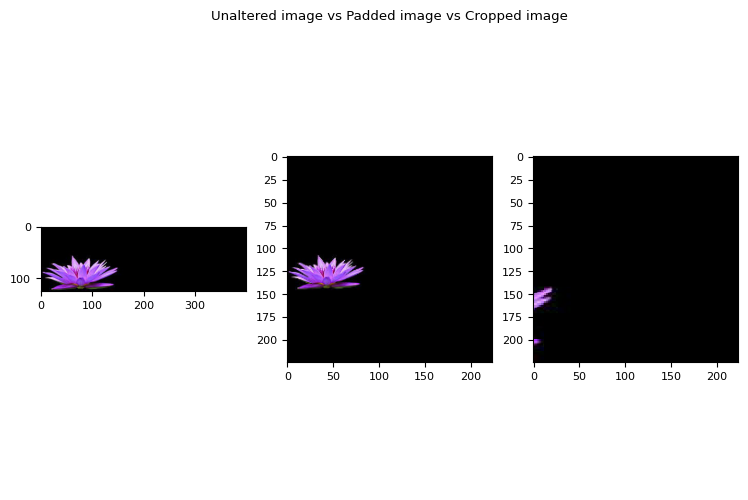

In [88]:
# Padding vs cropping
plt.figure(figsize=(9, 6))
plt.title('Unaltered image vs Padded image vs Cropped image')
plt.axis('off')
# Defining a path to an image that illustrates the difference between padding and cropping
image_path = train_dir + '\\Lilly\\334c1f79fd.jpg'

# Displaying unaltered image on the left
ax = plt.subplot(1, 3, 1)
img = mpimg.imread(image_path) / 255.0 # Read the image and normalise so it can be displayed properly with pyplot
plt.imshow(img)

# Displaying padded image in the centre
ax = plt.subplot(1, 3, 2)
img = tf.convert_to_tensor(img, dtype=tf.float32)  # resize_with_pad takes a tensor so we convert the image into one here
img = tf.image.resize_with_pad(img, 224, 224)  # generates black (0) padding where needed
plt.imshow(img.numpy())

# Displaying cropped image on the right
ax = plt.subplot(1, 3, 3)
img = utils.load_img(image_path, target_size=input_shape, keep_aspect_ratio=True)  # keep_aspect_ratio crops the image from the center
plt.imshow(img)

plt.show()


The next preprocessing step is <b>normalisation</b>. We will use min-max normalisation to make all pixel values from the range 0 - 255 to 0 - 1.

In [89]:
# Min-max normalisation
# x represents image data so we divide it by 255 to normalise each image's pixel values
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
valid_ds = valid_ds.map(lambda x, y: (x / 255.0, y))

### 1.2 Data visualisation

Here we will visualise some of the data.<br>
First we will display a <b>sample image of each class</b> from the training dataset.
The images contain varying backgrounds and are of varying dimensions. But in our datasets we have scaled them all down to 224x224 and zero-padded them for use with our models.<br><br>
Next we will display the <b>class distribution</b> for the training dataset and the testing dataset. As can be seen, the training dataset is entirely evenly distributed, with each class having 400 training images. 80 images of each class are being reserved for validation in accordance with our 80/20 training/validation split. <br>
The testing dataset is also evenly distributed for the most part. The only minor difference is that there are 92 test images for the Daisy class and 89 for the Orchid class. Every other class has 100 test images each.



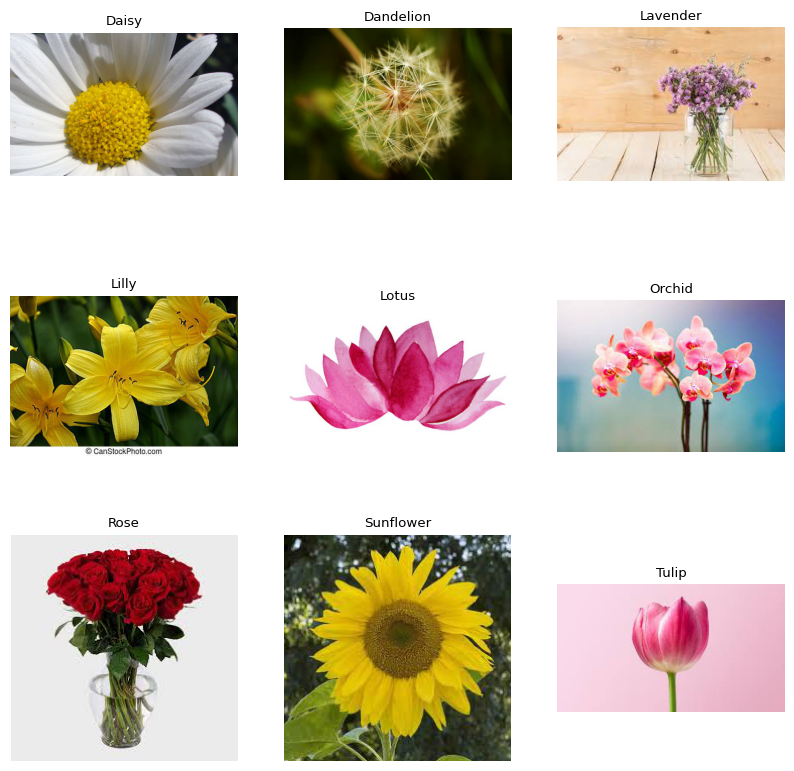

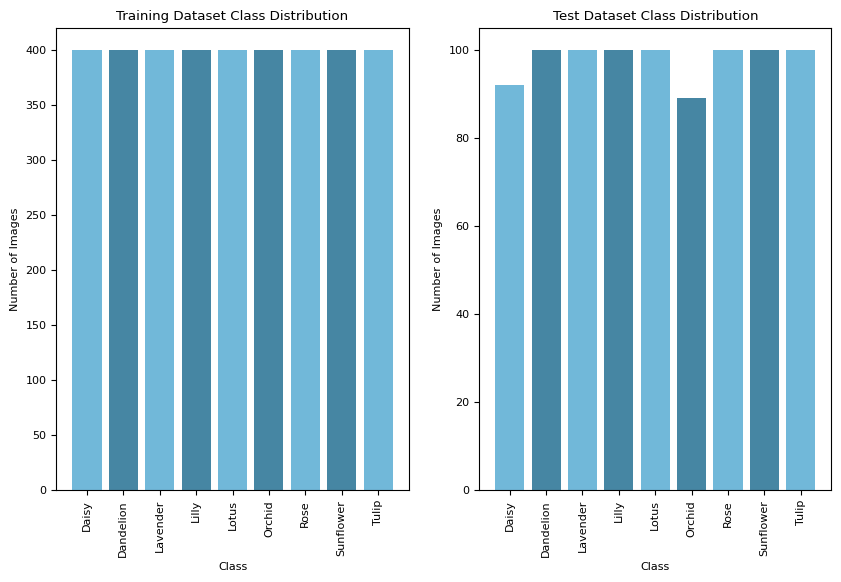

In [90]:
# Data visualisation

# Displaying sample images from the training dataset on a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
# Flattening axes to easily loop through them
axes = axes.flatten()
# For each class name
for i, class_name in enumerate(class_names):
    image_file = os.listdir(train_dir + '\\' + class_name)[0] # This will get the first image filename in each class
    image_path = train_dir + '\\' + class_name + '\\' + image_file # Constructing the full path to the image
    img = mpimg.imread(image_path)
    axes[i].imshow(img) # Show each image
    axes[i].set_title(class_name) # Display the type of flower it is
    axes[i].set_axis_off()

# Visualising class distribution for the training dataset and the testing dataset
plt.figure(figsize=(10, 6))

# This array stores the number of images per class
class_distribution = []
for name in class_names:
    class_dir = os.path.join(train_dir, name) # This gets the path to each classes' directory
    class_distribution.append(len(os.listdir(class_dir)))  # This gives us the length of the array of files in class_dir

ax = plt.subplot(1, 2, 1)
# Displays a bar chart of the class distribution with alternating colours
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Training Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
# Rotating x ticks for readability
ax.tick_params(axis='x', labelrotation=90)

# Now we do the same with the testing dataset
class_distribution = []
for name in class_names:
    class_dir = os.path.join(test_dir, name)
    class_distribution.append(len(os.listdir(class_dir)))

ax = plt.subplot(1, 2, 2)
ax.bar(class_names, class_distribution, color=['#71b8d9', '#4686a3'])
ax.set_title('Test Dataset Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.tick_params(axis='x', labelrotation=90)

## 2 The network structure and hyperparameters

### 2.1 GoogLeNet
Below are diagrams representing the architecture of GoogLeNet. <br>
![googlenet-architecture](https://drive.google.com/uc?id=1tWUNza79fQnQ-aJm-tc4hZw-aHEVCD5R) <br>
<i>GoogLeNet architecture</i> <br>
![inception-module](https://drive.google.com/uc?id=1RDRB1u-p2nup2MeYcCS9TkyXSbC_t6Qr) <br>
<i>Inception module</i> <br>
![auxiliary-classifier](https://drive.google.com/uc?id=145__39f0Z28chCQF0dGZ6IfeQKQt3Nvj) <br>
<i>Auxiliary classifier</i> <br><br>
GoogLeNet is a complex model that notably uses significantly less parameters than AlexNet through the use of inception modules. <br>
Inception modules have four paths that can capture different features which are then concatenated at the end. 1x1 convolutions are used to reduce the number of channels in the feature maps and to assist in deeper convolutions using ReLU activation. Then other operations can be performed, namely 3x3 convolution, 5x5 convolution and max-pooling which all serve to capture different patterns or features in the data. The convolutions of varying sizes can capture patterns at different scales while the pooling emphasises the most significant pixels in a region. All these operations use same-padding to retain their resolution as they are concatenated at the end, which essentially puts all their channels together, retaining all the information gleaned from these paths. For example if the 4 paths have a total of 50 channels combined, the output of concatenation would be their height x width x 50. <br>
An inception network such as GoogLeNet uses various inception modules often reducing their resolution as it gets deeper through the use of pooling with a stride greater than 1, often 2 to halve the resolution. This type of network allows for high performance with lower computational demands. The model we define in the below code cell has ~10,000,000 parameters, whereas AlexNet may have over 6 times that - a massive reduction in parameters thanks to inception modules. This design can also be considered intuitive as it aggregates visual information processed at different scales simultaneously meaning a richer set of features are learned. <br><br>
The GoogLeNet architecture makes use of inception modules to form a complex CNN alongside a few convolutional layers and pooling to reduce resolution as we go deeper. The input size is 224x224x3. While the model is about 27 layers deep the total number of layers is over 4 times the size since inception modules have simultaneous paths. We have added batch normalization after the convolutions with larger receptive fields in the architecture (outside of inception modules) to help with convergence. The final layers use average pooling to effectively flatten the feature map by getting the average value of the 7x7 input field which had resulted in improved accuracy for the authors of GoogLeNet. Lastly 40% dropout is used as a form of regularisation that reduces overfitting by forcing the model to learn a robust and complete set of features. Then lastly a fully-connected layer using softmax and 9 units generates our one-hot encoded output. <br><br>
Since the network is deep, there could be issues with backpropagating gradients. Auxiliary classifiers were introduced to tackle this and mitigate the effects of vanishing/exploding gradients. An auxiliary classifier are placed after the third and sixth inception modules since even at this point in the network there are some valuable features gleaned. This manages to ensure the gradient is propagated effectively while also not compromising classification performance. These auxiliary classifiers' losses are weighted at 0.3 of the main loss each to balance the training process. <br>
The auxiliary classifier consists of an average pooling layer, 1x1 convolutional layer, then flattens the feature map for a fully connected layer with 1024 units and 70% dropout is performed before the output fully connected layer. We have altered this to 50% as 70% seemed to be too high hindering our learning. <br><br>
He Normal weight initialisation is used since it is designed to improve performance for networks using ReLU activation which GoogLeNet does. Since ReLU can lead to sparse activations as all neurons 0 and below output only 0, so only positive neurons are active. He Normal initialisation improves the flow of gradient by initialising weights based on a normal distribution with mean of 0 and standard deviation of the root of 2 over the number of input neurons for the layer. This leads to higher variance which reduces the impact of sparse activation while also avoiding the other extreme of exploding gradients. <br><br>
The code block below also contains some preparatory code for fine-tuning our configuration which is explained in further depth under the <b>Optimisers</b> section. <br>
Our initial epoch value is 50 but we will see if so many epochs are needed by using a early stopping callback when we are no longer bettering our performance in training. This is explained more in later code blocks.

In [7]:
# This is a helper function that creates an optimiser with a specified learning rate (LR)
# This is used since we want to find the best combination of optimiser and LR
# As can be seen, we will be testing 4 optimisers: SGD, RMSProp, Adam, and Lion
def make_optimiser(optimiser, learning_rate):
    match(optimiser):
        case 'sgd':
            return SGD(learning_rate=learning_rate)
        case 'rmsprop':
            return RMSprop(learning_rate=learning_rate)
        case 'adam':
            return Adam(learning_rate=learning_rate)
        case 'lion':
            return Lion(learning_rate=learning_rate)

# Full GoogleNet architecture

# A helper function to easily define inception modules
def build_inception_module(input_layer, filters):
    # First path with 1 1x1 convolutional layer
    path1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)

    # Second path using a 3x3 convolutional layer with a 1x1 to reduce dimensionality
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=HeNormal())(path2)

    # Third path using a 5x5 convolutional layer with a 1x1 to reduce dimensionality
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5, 5), padding='same', activation='relu', kernel_initializer=HeNormal())(path3)

    # Fourth path using max pooling wih a 3x3 pool size to extract the most significant pixels followed by a 1x1 convolutional layer
    path4 = MaxPool2D(pool_size=(3, 3), strides=(1, 1), padding='same')(input_layer)
    path4 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(path4)

    # Here we concatenate the layers into one layer with depth of the sum of the 4 paths.
    # So the depth of the concatenated layer will be filters[0] + filters[1][1] + filters[2][1] + filters[3]
    inception_layer = Concatenate(axis=-1)([path1, path2, path3, path4])
    return inception_layer

# A helper function to easily define auxiliary classifiers
def build_auxiliary_classifier(input_layer, name):
    # 5x5 average pooling with stride of 3 reducing the resolution by a third of the original
    aux = AvgPool2D(pool_size=(5, 5), strides=3, padding='valid')(input_layer)
    # A 1x1 convolutional layer to reduce dimensionality
    aux = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu', kernel_initializer=HeNormal())(aux)
    # Flattening for our fully connected layers
    aux = Flatten()(aux)
    # A fully connected layer with 1024 units using ReLU activation
    aux = Dense(units=1024, activation='relu', kernel_initializer=HeNormal())(aux)
    # 50% dropout (lowered from the 70% in the original GoogLeNet)
    aux = Dropout(rate=0.5)(aux)
    # Output using softmax and one-hot encoding
    aux = Dense(units=NB_CLASSES, activation='softmax', name=name)(aux)

    return aux

# This function builds all layers in the GoogLeNet architecture
def build_googlenet_model(tuner = None):
    # Input images are 224x224 with 3 channels for RGB
    input_layer = Input(shape=(224, 224, 3))

    # First some initial larger convolution is performed with a stride of 2, detecting larger patterns and halving our resolution
    layer = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu', kernel_initializer=HeNormal())(input_layer)
    layer = BatchNormalization()(layer)
    # Again we simplify the input further with a max pooling of stride 2
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # Smaller convolution is performed here with a 1x1 and 3x3
    layer = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', kernel_initializer=HeNormal())(layer)
    layer = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_initializer=HeNormal())(layer)
    layer = BatchNormalization()(layer)
    # The resolution is reduced once more before the inception modules
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    # 2 inception modules are used with different filter number configurations
    layer = build_inception_module(layer, [64, (96, 128), [16, 32], 32])
    layer = build_inception_module(layer, [128, (128, 192), [32, 96], 64])

    # Halving the resolution again, at this point the dimensions are 14x14x480
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [192, (96, 208), [16, 48], 64])
    # Our first auxiliary classifier is here and takes the feature maps from the last inception module (14x14x512)
    # This will help backpropagation of gradient to the previous layers
    auxiliary1 = build_auxiliary_classifier(layer, 'aux1')
    # Three more inception modules
    layer = build_inception_module(layer, [160, (112, 224), [24, 64], 64])
    layer = build_inception_module(layer, [128, (128, 256), [24, 64], 64])
    layer = build_inception_module(layer, [112, (144, 288), [32, 64], 64])
    # The second auxiliary classifier takes an input of 14x14x528
    auxiliary2 = build_auxiliary_classifier(layer, 'aux2')
    layer = build_inception_module(layer, [256, (160, 320), [32, 128], 128])

    # At this point we halve the resolution again using max pooling. Size is now 7x7x832
    layer = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(layer)

    layer = build_inception_module(layer, [256, (160, 320), (32, 128), 128])
    # After this final inception module we will have 1024 7x7 feature maps
    layer = build_inception_module(layer, [384, (192, 384), (48, 128), 128])

    # This gets the average of the 7x7 field for each feature map resulting in 1x1x1024
    layer = AvgPool2D(pool_size=(7, 7), strides=1, padding='valid')(layer)
    layer = Flatten()(layer)
    # 40% dropout for robust learning
    layer = Dropout(0.4)(layer)
    # Finally we output our final one-hot encoded classification with softmax
    output_layer = Dense(units=NB_CLASSES, activation='softmax', name='output')(layer)

    # Now we create our model making sure to use the three outputs - the two auxiliary layers and the final output layer
    model = Model(inputs=input_layer, outputs=[output_layer, auxiliary1, auxiliary2], name='GoogLeNet')
    
    # If a tuner is specified we will use this code block to configure our optimiser & LR
    # Otherwise we skip this step and the model is compiled manually
    if tuner is not None:
        # These two choices give us 4x4 = 16 different combinations to test
        learning_rate = tuner.Choice('learning_rate', [0.001, 0.0001, 0.00005, 0.00001])
        optimiser_choice = tuner.Choice('optimiser', ['sgd', 'rmsprop', 'adam', 'lion'])
    
        # Here we initialise our optimiser using the results from the choices
        optimiser = make_optimiser(optimiser_choice, learning_rate)
    
        # We compile our model with the optimiser
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy', 'accuracy', 'accuracy'])
        
    return model

# Building a sample model to display a summary of the architecture                                               
googlenet = build_googlenet_model()
googlenet.summary()

Model: "GoogLeNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        768 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]  

 Total params: 10,331,979 (39.41 MB)

 Trainable params: 10,331,467 (39.41 MB)

 Non-trainable params: 512 (2.00 KB)

### 2.2 ResNeXt
#### Weight Initialization
ResNext uses the Keras he normal initializer to initialize their model weights. Weights get sampled from a normal distribution centered on 0 and a standard deviation that is dependent on the input shape (source: https://keras.io/api/layers/initializers/).

#### Activation Functions
ResNext mainly uses ReLU as an activation function and Softmax for the final output.

##### ReLU (Rectified Linear Unit)
The ReLU returns its input, if it's non-negative. As most of the activation functions, it introduces non-linearity that ensures that the model can deal with complex data. Compared to other activation functions that are used in hidden layers, it prevents the problem of vanishing gradients.
* Formula: f(x) = max(0, x)

##### Softmax:
In the last layer, by using the softmax activation function both architectures ensure that the output can be interpreted as probabilities for the different classification classes. It ensures values between 0 and 1 for each output, that in sum add up to 1.
* Formula: p(i) = exp(x(i)) / (exp(x(1)) + exp(x(2)) + … + exp(x(n)))
* Where p(i) is the probability of the ith class, x(i) is the ith input into the activation function and n is the number of inputs into the activation function
* exp means the exponential function

#### Batch Normalization
Batch Normalization was originally introduced to solve the vanishing and exploding gradients problem during training, where other solutions mainly offer improvements at the beginning of the training (such as ReLU or He initialization). It improves accuracy and decreases sensitivity to the weight initialization. An additional benefit is that it works as a regularizer against overfitting (= increasing generalizability). In the ResNext model it is applied before the activation function of each layer. During training, batch normalization works by calculating a common mean and standard deviation of a batch, z-transforming all data in the batch and then applying a scaling and an offset, both of which are also adapted (learned) during the learning phase. Additionally, a mean and standard deviation across all batches are learned and can be applied after training, when the model is applied to the test data. Source: Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (Second edition). O’Reilly Media, Inc.

#### Regularization
o	Generally, Regularization helps to reduce the risk of overfitting to the training data. Besides Batch Normalization, that offers regularization as a side benefit, ResNext also uses L2-Regularization in all its convolutional layers. At each training step a regularization loss is calculated. This is then added to the originally calculated loss. The regularization loss is computed by multiplying the weight decay parameter with the sum across all squared weights of the model. This penalizes large weight values. Source: https://www.geeksforgeeks.org/l1l2-regularization-in-pytorch/#concept-of-l2-regularization

#### Hyperparameters
##### External Hyperparameters
* Input Shape: Determined by the decision what size the images get resized to during preprocessing (in the Dataset loading functionality of Keras);
* Depth: Number of layers (or blocks, depending on whether a single number or an array is provided) in the network model; Opting for a higher depth would mean adding additional bottleneck blocks which themselves contain the group convolution blocks;
* Cardinality (unique to ResNext): Number of groups that get processed in parallel within the group convolution; The paper shows that increasing cardinality can improve accuracy while maintaining complexity and it shows to be more effective than increasing depth or width. Source: Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated Residual Transformations for Deep Neural Networks. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 5987–5995. https://doi.org/10.1109/CVPR.2017.634
* Width: number of filters per group within the group convolution, controls the number of “simple transformations” (inner product as we’re used to from simple neurons)
* Weight Decay (L2 Regularization): Controls how much large weights are penalized
* Weights (pretrained model or not) / include_top: Determine whether pretrained weights (in this case just pre-trained weights of the cifar-10 training set) will be used for initialization; include_top refers to whether the final layer will be included
* Loss function: Function that determines how the difference between the prediction of the model and the actual classification of a specific input will be operationalized
* Optimizer: Function that determines how the loss function will be used to adapt weights within the model and thus learn
* Metrics: Used to evaluate the model (during training to track progress and after training on the test dataset)

##### Internal Hyperparameters
Mostly not intended to be changed: Part of the internal ResNeXt Code
* Padding: Defined for a single layer (although the same across all layers), whether input is padded so that the output size isn’t reduced merely by using a filter of a non-zero dimensionality
* Filter size: Defined for a single layer, defines the size of the window of the input that is convoluted
* Filter number: Defined for a single layer, determines the number of the output feature maps
* Strides: Defined for a single layer, determines how the Kernel moves across the input (the step sizes).
* Kernel initializer: Defined for a single layer (although it should be the same across all layers), determines how the weights within the kernels of one layer are initialized prior to training
* Kernel regularizer: Defined for a single layer (although it should be the same across all layers), determines if a L1 or L2 regularizer is used. Both adapt the loss function by penalizing weights, for better generalizability of the training results
* Activation function: Defined for a single layer (although it should usually be the same across all layers except from the output layer(s)). This determines how non-linearity is introduced into the model by applying a non-linear function to the data.

#### Unique Features of ResNeXt
##### Residual Learning (or "Skip connections")
It’s a solution for vanishing / exploding gradients during backpropagation in deep networks. In ResNext (and other architectures using residual learning), the output activation of one layer is added to the output of another layer while skipping intermediate layers. Training will be sped up by this, since the network doesn’t have to “wait” for all layers to have started learning to make progress. However, both outputs need to have the same shape and thus the output of the earlier layer might need to be modified (which is done by a 1x1 Convolution in ResNext). Sources: https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/ and Géron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems (Second edition). O’Reilly Media, Inc.

#### Group Convolution
In ResNext, there is a “split-transform-merge” strategy (because input channels are split into groups and independently convoluted before being combined into an overall output) that can also be observes in Inception modules (which are used in GoogleLeNet). However, Inception modules are hard to design, because adaptation of many factors and hyperparameters is necessary. ResNext on the other hand uses the same topology in all of the paths, which reduces the hyperparameters needed and makes the number of paths an investigable parameter. Source: Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated Residual Transformations for Deep Neural Networks. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 5987–5995. https://doi.org/10.1109/CVPR.2017.634

#### Modularization
There is one main building block (Bottleneck block) that is repeated, which leads to a simple architecture with only few hyperparameters that need to be decided upon and easy extensibility. Source: Xie, S., Girshick, R., Dollár, P., Tu, Z., & He, K. (2017). Aggregated Residual Transformations for Deep Neural Networks. 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 5987–5995. https://doi.org/10.1109/CVPR.2017.634

#### Additional Note
Not unique to ResNext, but an interesting aspect of the architecture is that the bias that is usually also learned in a layer gets omitted in ResNext. This makes sense, since the model makes heavy use of Batch Normalization, which introduces its own learnable shifting parameter. Source: Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. Proceedings of the 32nd International Conference on International Conference on Machine Learning - Volume 37, 448–456.

In [ ]:
# Building the ResNext Model Architecture

CIFAR_TH_WEIGHTS_PATH = ''
CIFAR_TF_WEIGHTS_PATH = ''
CIFAR_TH_WEIGHTS_PATH_NO_TOP = ''
CIFAR_TF_WEIGHTS_PATH_NO_TOP = ''

IMAGENET_TH_WEIGHTS_PATH = ''
IMAGENET_TF_WEIGHTS_PATH = ''
IMAGENET_TH_WEIGHTS_PATH_NO_TOP = ''
IMAGENET_TF_WEIGHTS_PATH_NO_TOP = ''

'''
Checks requirements and sets up relevant variables before triggering the creation of the network model
Can also load pre-trained weights into the model

Parameters:
- input_shape: shape of the images that are used in training and using (/testing) of the model
- depth: number of layers (or blocks) in the ResNext model
- cardinality: number of independently processed groups in the model
- width: Number of filters produced feature maps per group
- weight_decay: L2 Regularization Penalty
- include_top: determines if the last (dense) layer is included in the model
- weights: can be either cifar10 (pre-trained model weights) or None (which means that they get initialized by the he_normal initializer later)
- input_tensor: existant if there is any input that needs to be passed into the model (e.g. due to previous connected layers / information from pre-training)
- pooling: indicates if average or maximum pooling is used after the first block of the network
- classes: number of output classes for the classification
'''
def ResNext(input_shape=None, depth=29, cardinality=8, width=64, weight_decay=5e-4,
            include_top=True, weights=None, input_tensor=None,
            pooling=None, classes=9):

    # Checks if the weights argument is given correctly (either 'cifar10' for pretrained weights or None for usage of initializers)
    if weights not in {'cifar10', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `cifar10` '
                         '(pre-training on CIFAR-10).')

    # Checks if arguments 'weights', 'include_top' and 'classes' are set consistently -> if the pretrained
    # weights are used and the last layer from the pretrained model should be used, the output classes must be the
    # same as for CIFAR10 (which means that we can't include the last layer if we wanted to use the pre-trained model,
    # since we only have 9 classes)
    if weights == 'cifar10' and include_top and classes != 10:
        raise ValueError('If using `weights` as CIFAR 10 with `include_top`'
                         ' as true, `classes` should be 10')

    # If depth is an integer, it indicates the overall number of layers in the model, that need to be equally assigned
    # to the blocks used in the model. To be able to achieve that, depth must be dividable by 9 after the
    # input and output layer were deducted from the depth
    if type(depth) == int:
        if (depth - 2) % 9 != 0:
            raise ValueError('Depth of the network must be such that (depth - 2)'
                             'should be divisible by 9.')

    # validation of the input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=256,
                                      min_size=8,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    # Creates placeholder input of the specified shape if no specified tensor needs to be inputted into the model
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    # If there is a specified input tensor that is provided, if it's a keras tensor, it is used directly
    # Otherwise a keras tensore gets instaniated with the specified content
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    # Triggers creation of the model (output)
    x = __create_res_next(classes, img_input, include_top, depth, cardinality, width,
                          weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Creates Keras model
    model = Model(inputs, x, name='resnext')

    # If the weights are initialized with the cifar-10 pre-trained weights, then
    # the following block applies, otherwise the model is returned.
    if weights == 'cifar10':
        # If depth, cardinality and width are the same as during pre-training, the weights can be applied
        # Otherwise there would be a mismatch between given, pre-trained weights and model weights in the newly created model
        if (depth == 29) and (cardinality == 8) and (width == 64):
            # Check where in the input shape the channels are specified and stored
            # Depending on that, get weights stored in the same format
            # which one needs to be taken is specified by having different file paths to the different storage versions
            # This is the same for the model with or without the last layer (and thus the corresponding weights)
            if K.image_data_format() == 'channels_first':
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels.h5',
                                            CIFAR_TH_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_th_dim_ordering_th_kernels_no_top.h5',
                                            CIFAR_TH_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                # weights are loaded from the specified path (that belongs to weights stored in the
                # channel-first format and with ot without the last network layer as specified)
                model.load_weights(weights_path)

                # Converts the convolution kernels / weights in the model from Theano to TensorFlow
                if K.backend() == 'tensorflow':
                    warnings.warn('Warning')
                    convert_all_kernels_in_model(model)
            else:
                if include_top:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels.h5',
                                            CIFAR_TF_WEIGHTS_PATH,
                                            cache_subdir='models')
                else:
                    weights_path = get_file('resnext_cifar_10_8_64_tf_dim_ordering_tf_kernels_no_top.h5',
                                            CIFAR_TF_WEIGHTS_PATH_NO_TOP,
                                            cache_subdir='models')

                # weights are loaded from the specified path (that belongs to weights stored in the
                # channel-last format and with ot without the last network layer as specified)
                model.load_weights(weights_path)

                # Converts the convolution kernels / weights in the model to Theano
                if K.backend() == 'theano':
                    convert_all_kernels_in_model(model)

    return model


'''
Defines first higher-level block in the architecture (block 0) that performs one 2D Convolution
Parameters:
- weight_decay: L2 Regularization Penalty
- input: Input to the Convolution
'''
def __initial_conv_block(input, weight_decay=5e-4):
    # channel_axis defines where to find the channel data (in the first position of the single input or in the last position)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Convolution layer with regularization: Kernels of size 3x3 are moved across the image and produce 64 feature maps (one per Kernel)
    # The Kernel is initialized with the h_normal initializer and will learn new weights during training periods;
    # Kernel_regularizer prevents overfitting (=improves generalizability), more about this separately
    # All of the other Conv2D layers are analogous (with differing number of kernels, kernel sizes and strides), thus will not be described in detail within the code
    x = Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(input)
    # Batach normalization that improved training, more about this separately, the other Batch Normalization layers are analogous, thus will not be described in detail within the code
    x = BatchNormalization(axis=channel_axis)(x)
    # Activation function that introduces non-linearity (more about this separately)
    x = Activation('relu')(x)

    return x

# Not used by us
def __initial_conv_block_imagenet(input, weight_decay=5e-4):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(64, (7, 7), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay), strides=(2, 2))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    return x

'''
Defines important (and distinguishing) component in the architecture (part of higher-order blocks 1 to N)

Parameters:
- input: input into the defined layers
- grouped_channels: number of filters / feature map outputs per independent group
- cardinality: number of independently processed groups in the model
- strides: parameter of the 2D Convolution, determines difference between two kernel positions
- weight_decay: L2 Regularization Penalty
'''
def __grouped_convolution_block(input, grouped_channels, cardinality, strides, weight_decay=5e-4):
    init = input
    # channel_axis defines where to find the channel data (in the first position of the single input or in the last position)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Used to store the outputs for each group that later get combined
    group_list = []

    # There is only one group, standard convolution is applied with Batch normalizationa and a ReLU-activation function
    if cardinality == 1:
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        return x

    # Cardinality defines the number of independently processed groups; This for loop takes one processing group at a time
    for c in range(cardinality):
        # Defines a Lambda-layer which is used to introduce custom transformations
        # In this layer, the channels of the input get grouped into subsequent groups of size group_channels
        # Where the channels are extracted from in the input depends on if the channel information are stored first or last
        x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels]
        if K.image_data_format() == 'channels_last' else
        lambda z: z[:, c * grouped_channels:(c + 1) * grouped_channels, :, :])(input)

        # 2D convolution gets applied to every channel-group
        x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(strides, strides),
                   kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(x)

        # The results are stored in a common list
        group_list.append(x)

    # All results of the independent convolutions are combined along the channel_axis dimension to form the final feature map
    group_merge = concatenate(group_list, axis=channel_axis)
    x = BatchNormalization(axis=channel_axis)(group_merge)
    x = Activation('relu')(x)

    return x


'''
Defines component in the architecture (part of higher-order blocks 1 to N)
that makes use of the distinguishing group convolution component and contains residual connections.

Parameters:
- input: input into the defined layers
- filters: Number of kernels for convolution layers and number of Kernels summed up across groups for group convolution layer
- cardinality: number of independently processed groups in the model
- strides: parameter of the 2D Convolution, determines difference between two kernel positions
- weight_decay: L2 Regularization Penalty
'''
def __bottleneck_block(input, filters=64, cardinality=8, strides=1, weight_decay=5e-4):
    init = input

    # Number of kernels / filters for convolution of a single group in the group convolution layer
    grouped_channels = int(filters / cardinality)
    # channel_axis defines where to find the channel data (in the first position of the single input or in the last position)
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    # Number of the filters of init (original input that is later fed back into the model) should be 2*filters argument, otherwise the data is convoluted to contain 2*filters as the output
    # This is important to ensure that init and x have the same shape once they get added together (for the residual connection)
    # Checking at the position of the channel information which is either the first or the last
    if K.image_data_format() == 'channels_first':
        if init.shape[1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)
    else:
        if init.shape[-1] != 2 * filters:
            init = Conv2D(filters * 2, (1, 1), padding='same', strides=(strides, strides),
                          use_bias=False, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(init)
            init = BatchNormalization(axis=channel_axis)(init)

    # first convolution layer within the bottleneck block
    x = Conv2D(filters, (1, 1), padding='same', use_bias=False,
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('relu')(x)

    # distinguishing component, contains second convolution layer within the bottleneck block
    x = __grouped_convolution_block(x, grouped_channels, cardinality, strides, weight_decay)

    # third convolution layer within the bottleneck block
    x = Conv2D(filters * 2, (1, 1), padding='same', use_bias=False, kernel_initializer='he_normal',
               kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization(axis=channel_axis)(x)

    # Elementwise addition, adds the original input of the bottleneck block to the transformed output
    # from the convolutional layers, including the group convolution (residual connection)
    x = add([init, x])
    x = Activation('relu')(x)

    return x


'''
Creates ResNext architecture (output).
Parameters:
- nb_classes: Number of output classes; in our case 9 (flower classes that can be differentiated)
- img_input: In our case placeholder with the right input shape
- include_top: Determines whether the output will be a probabilities for the classes or 1D feature maps (number determined by amount of filters in the previous layer)
- depth: number of layers (or blocks)
- cardinality: number of independently processed groups
- width: Number of filters produced feature maps per group
- weight_decay: L2 Regularization Penalty
- pooling: indicates if average or maximum pooling is used after the first block of the network
'''
def __create_res_next(nb_classes, img_input, include_top, depth=29, cardinality=8, width=4,
                      weight_decay=5e-4, pooling=None):
    # If depth is a list or a tuple, it's interpreted as a custom specification about the number of bottleneck (-> grouped convolution) blocks per higher-order block
    if type(depth) is list or type(depth) is tuple:
        N = list(depth)
    # Otherwise, if depth is single number, it specifies the overall depth / number of layers of the network
    # In that case a default of 3 higher-order blocks will be defined (additionally to a first and last layer, thus -2 to determine blocks per higher-order block),
    # that are evenly filled with bottleneck (-> grouped convolution) blocks (which all contain 3 Convolution layers -> dividing by 3*3=9)
    else:
        N = [(depth - 2) // 9 for _ in range(3)]

    # Width is the number of feature map outputs / filters per independently processed group, thus the overall amount of filters can be calculated by the following formula
    filters = cardinality * width
    filters_list = []

    # For every higher-order block the number of filters (in the convolutional layers of the bottleneck blocks) is assigned
    # It starts of with the overall width defined by cardinality and per-group width and increases by factor 3 with every higher-order block
    for i in range(len(N)):
        filters_list.append(filters)
        filters *= 2

    # First higher-order block (block 0, does not use bottleneck block and thus is not counted "properly")
    x = __initial_conv_block(img_input, weight_decay)

    # Higher order block 1 (no downsampling, but bottleneck blocks with the number determined previously by the depth argument)
    for i in range(N[0]):
        x = __bottleneck_block(x, filters_list[0], cardinality, strides=1, weight_decay=weight_decay)

    N = N[1:]  # remove the first block from block definition list, because it was used
    filters_list = filters_list[1:]  # remove the first filter from the filter list, because it was used

    # higher order block 2 to N: While the number of filters doubles with each higher-order block as defined previously,
    # strides 2 leads to downsampling by factor 2, to ensure computational complexity stays approximately the same
    for block_idx, n_i in enumerate(N):
        for i in range(n_i):
            if i == 0:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=2,
                                       weight_decay=weight_decay)
            else:
                x = __bottleneck_block(x, filters_list[block_idx], cardinality, strides=1,
                                       weight_decay=weight_decay)

    # If the output layers are included, global average pooling (one average per feature map) is applied
    # and a dense (fully connected) layer with activation function softmax produces probabilities for the classification output classes
    if include_top:
        x = GlobalAveragePooling2D()(x)
        x = Dense(nb_classes, use_bias=False, kernel_regularizer=l2(weight_decay),
                  kernel_initializer='he_normal', activation='softmax')(x)
    # If the final output layer is not included, pooling is applied according to the pooling-argument
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    return x

In [ ]:
# Building the ResNext Model Architecture
import numpy as np

# creates model that accepts images of shape 224x224x3 as input, has 29 convolution layers, 8 independently processed channel-groups in the group convolution and a width of 8 (number of filters)
model = ResNext((224, 224, 3), depth=29, cardinality=8, width=8)

# Compiling the Model, more information on optimizer and loss function separately
model.compile(optimizer=Lion(learning_rate=1e-4), loss=categorical_focal_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

Model: "resnext"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 224, 224,  │      1,728 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 224, 224,  │      4,096 │ activation_28[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_72 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_73 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_74 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_75 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_76 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_77 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_78 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_79 (Lambda)  │ (None, 224, 224,  │          0 │ activation_29[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 224, 224,  │        576 │ lambda_72[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 224, 224,  │        576 │ lambda_73[0][0] 

 Total params: 1,440,192 (5.49 MB)

 Trainable params: 1,427,520 (5.45 MB)

 Non-trainable params: 12,672 (49.50 KB)

***ResNext-50 Model Review***<br>
******
The main takeaway from this model summary is the sheer size. This is mostly due to the width parameter in the model constructor, which controls the size of each layer. The original version of this model had a width of 64, and it proved to be much too large to train. For reference, we signed up for Google Colab Pro for use of their highest-power machines, and this model burned through all 360GB of available RAM. To actually run this model, we opted to reduce the width parameter to 8, then 4.

The severe memory requirements ResNext comes with is actually quite a limiter. One must balance the size and effectiveness of the model with the number of epochs it can run through before crashing the machine. To reach its full potential, one would need access to a HPC unit. This was an error in our planning, as if we had hired out the El Capitan computer, currently the number one ranked machine on the [Top500](https://top500.org), ResNext MIGHT have been able to run in its desired state.

In [ ]:
plot_model(model, to_file="my_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 3 Loss Function
Since we are using one-hot encoding we chose to go with <b>categorical crossentropy</b> (CCE) for GoogLeNet which is best for one-hot encoded classification tasks. <br>
What this does is measures the sum of the probabilities assigned to incorrect classes since each incorrect class should be assigned a probability of 0, while the correct class should be assigned a probability of 1. <br>
Sparse categorical crossentropy is a similar loss function that achieves the same goal but for output encoded using numeric/ordinal encoding. <br>
Other loss functions such as root mean squared error or mean absolute error are better suited for regression tasks so we avoid using them here.

For ResNeXt, we chose to use <b>categorical focal crossentropy</b>. It is based on classical CCE, which gets multiplied by an additional factor. 
This factor consists of two components:
* Alpha: is a weighting factor that can be used to account for imbalanced classes. Our data did not suffer from imbalance, thus, further consideration of alpha was unnecessary. 
* (1-p_t)\*\*gamma, where:
    * gamma is called a focusing parameter controlling the focal effect on the cross entropy and 
    * p_t is the predicted probability for the true class
    * When p_t is large, we can speak of “easy examples” and the model is confident in predicting them. (1-p_t) becomes small and, controlled by gamma, there is a down-weighting effect on the contribution of these examples. Thus, training focuses more on the “hard” examples, where the predicted probability of the correct class is smaller, (1-p_t) gets closer to 1 and there will be less down-weighting of the contribution to the loss function.
Source: Lin, T.-Y., Goyal, P., Girshick, R., He, K., & Dollár, P. (2017). Focal Loss for Dense Object Detection. 2017 IEEE International Conference on Computer Vision (ICCV), 2999–3007. https://doi.org/10.1109/ICCV.2017.324

## 4 Optimiser
### 4.1 GoogLeNet Optimiser and Learning Rate Selection
There were four main optimisers that we investigated with our GoogLeNet architecture: Stochastic Gradient Descent (SGD), RMSProp, Adam, and Lion. <br>
- SGD was expected to be the least effective but serves as a baseline and also to test a gradient descent optimiser. Since our dataset has padding and noisy backgrounds it may take a long time to converge.
- RMSProp uses an adaptive learning rate and uses a moving average of squared gradients to adjust the learning rate.
- Adam is one of the most commonly used optimisers. It's similar to RMSProp in that it uses moving average as well but also considers momentum, the direction the gradients are moving in.
- Lion (Evolved Sign Momentum) is a newer optimiser discovered by Google Brain. It considers momentum like Adam, but uses the sign operation making each parameter updated by the same magnitude. This makes it memory efficient and supposedly outperforms Adam.

While it seems that Lion may be the best optimiser, we will test each optimiser with learning rates: 0.001, 0.0001, 0.00005, and 0.00001 using Hyperband. Hyperband uses brackets to determine the best performing model, taking the best 50% of models to the next bracket. By putting models with each optimiser with each learning rate into a Hyperband tuner we can determine the best pair in a reasonable amount of time. We are comparing our models on validation loss. <br><br>
Below we will begin the process of finding the best optimiser and learning rate for GoogLeNet.


In [8]:
# Instantiating our tuner to find the best performing optimiser and learning rate (LR) pair based on validation loss
tuner = kt.Hyperband(build_googlenet_model,
                     objective='val_loss',
                     max_epochs=epochs,
                     directory='googlenet',
                     project_name='GoogLeNet')

# Similar to fit, search will start training each model. It will only train for some epochs and then compare the results.
tuner.search(train_ds, validation_data=valid_ds, epochs=epochs, verbose=verbose)

# Gets the best optimiser and LR pair for use in subsequent models
best_pair = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'The best performing pair uses optimiser {best_pair.get('optimiser')} with learning rate {best_pair.get('learning_rate')}')

Trial 16 Complete [00h 01m 34s]
val_loss: 1.7669508457183838

Best val_loss So Far: 1.7669508457183838
Total elapsed time: 00h 26m 29s
The best performing pair uses optimiser lion with learning rate 0.0001


Lion with a LR of 0.0001 almost always ends up as the best performing optimiser. We will continue to use Lion, LR 0.0001 for cross-fold validation.

To determine a more optimal number of epochs to use in cross-fold validation we will use an early stopping callback. This callback keeps track of the highest validation accuracy. If this value has not been beaten in 5 epochs, then we stop training and use the epoch number where we achieved the highest validation accuracy as the 'best' number of epochs to train with.

In [13]:
# Now we can train a model with the best performing optimiser & LR pair to find an optimal number of epochs to use
# Build the model with the optimiser & LR
googlenet = build_googlenet_model()
# Instantiate the best performing optimiser & LR
optimiser = make_optimiser(best_pair.get('optimiser'), best_pair.get('learning_rate'))
# Compile our model with this optimiser
googlenet.compile(optimizer=optimiser,
                  loss={'output': 'categorical_crossentropy', 'aux1': 'categorical_crossentropy', 'aux2': 'categorical_crossentropy'},
                  loss_weights={'output': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  metrics=['accuracy', 'accuracy', 'accuracy'])

# This callback will stop training if validation accuracy has not seen a new max in 5 epochs (patience)
stop_early = EarlyStopping(monitor='val_output_accuracy', patience=5, verbose=1, mode='max')
# Now we train with 50 epochs which is likely more than needed in order to see how many epochs we actually should train with
history = googlenet.fit(train_ds, validation_data=valid_ds, epochs=epochs, batch_size=128, verbose=verbose, callbacks=[stop_early])

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 478ms/step - loss: 1.2829 - output_accuracy: 0.1943 - val_loss: 0.8713 - val_output_accuracy: 0.2347
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 508ms/step - loss: 0.6800 - output_accuracy: 0.4565 - val_loss: 0.6857 - val_output_accuracy: 0.3125
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 510ms/step - loss: 0.5020 - output_accuracy: 0.5392 - val_loss: 0.5850 - val_output_accuracy: 0.3542
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 527ms/step - loss: 0.3894 - output_accuracy: 0.6225 - val_loss: 0.4764 - val_output_accuracy: 0.4889
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 507ms/step - loss: 0.3243 - output_accuracy: 0.6728 - val_loss: 0.4286 - val_output_accuracy: 0.5333
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 45s 497ms/step - loss: 0.2695 - output_accuracy: 0.7219 - val_loss: 0.3200 - val_output_accuracy: 0.6403
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 46s 506ms/step - loss: 0.2326 - output_accuracy: 0.7499 - val_loss: 0.3096 - val_output_accuracy: 0.6542

In [14]:
# Get the validation accuracy for each epoch
val_accuracy_by_epoch = history.history['val_output_accuracy']
# Find the epoch number with the highest validation accuracy (+1 since arrays start at 0)
# Reassign epochs as this is now the number we will use for future training
epochs = val_accuracy_by_epoch.index(max(val_accuracy_by_epoch)) + 1
print(f'The model had the best validation accuracy after {epochs} epochs')

The model had the best validation accuracy after 18 epochs


### 4.2 ResNeXt Optimiser
In ResNeXt, we focused on Lion, since it turned out to perform best for the GoogleLeNet model. Additionally, we opted for Lion given the previous positive observations about its memory-efficiency compared to Adam and its advantages in terms of accuracy. Source: Chen, X., Liang, C., Huang, D., Real, E., Wang, K., Pham, H., Dong, X., Luong, T., Hsieh, C.-J., Lu, Y., & Le, Q. V. (2024). Symbolic discovery of optimization algorithms. Proceedings of the 37th International Conference on Neural Information Processing Systems, 49205–49233.

In [ ]:
# ResNext Model Training and eval

history = model.fit(train_ds, epochs=20, validation_data=valid_ds, validation_freq=1)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1279s 13s/step - accuracy: 0.2718 - loss: 6.6488 - val_accuracy: 0.2597 - val_loss: 6.3801
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1227s 14s/step - accuracy: 0.5091 - loss: 5.8446 - val_accuracy: 0.3069 - val_loss: 5.4616
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1223s 14s/step - accuracy: 0.5798 - loss: 5.1309 - val_accuracy: 0.3000 - val_loss: 4.8086
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1212s 13s/step - accuracy: 0.6181 - loss: 4.4640 - val_accuracy: 0.4097 - val_loss: 4.1170
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1220s 14s/step - accuracy: 0.6293 - loss: 3.8634 - val_accuracy: 0.3944 - val_loss: 3.6020
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1209s 13s/step - accuracy: 0.6665 - loss: 3.3312 - val_accuracy: 0.4208 - val_loss: 3.1107
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1220s 14s/step - accuracy: 0.7050 - loss: 2.8685 - val_accuracy: 0.3847 - val_loss: 2.7251
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1217s 14s/step - accuracy: 0.6933 - loss: 2.4817 - val_accu

Run One Analysis:

This was our original model's run, with a width of 8. The learning rate was set much too high, as seen by the overfitting, and due to the training time required, the epochs was set much too low. This is a prime example of the balancing act we had to perform between a ResNext model's potential strength and how muh training we could afford to give it.

## 5 Cross-fold validation
### 5.1 GoogLeNet
For GoogLeNet we are performing k-fold validation using 5 folds. This will train 5 models with an 80/20 train/val split where the validation split will represent a unique fifth for each model. Using different splits for validation can be useful in that different training data may provide better generalisation and we can also aggregate our results to make more balanced predictions. This is of course at the expense of greater computational demands since we have to train 5 models instead of just 1.<br>
We are using the epoch value and optimiser, learning rate pair that has worked best for us so far. <br>
We will also track the training for each model and save each model so that we can evaluate them. Cross-fold validation can produce different models and some may perform better. We can either choose the best model to use if we want or we can try aggregate the predictions of all of our models and see if that performs better.

In [18]:
# Training models with Cross Fold Validation

# We will need all of the training data for this so we load it in
full_train_ds = load_dataset(train_dir)

# Splits corresponds to the number of folds
splits = 5
# Total number of elements in the training data
dataset_size = len(list(full_train_ds))
# The number of elements in each fold
fold_size = dataset_size // splits
# The results and predictions of each fold will be stored in these arrays
googlenet_scores = []
# Store the models for evaluation later
googlenet_models = []

# For each fold we will split the training data into 5 parts, 4 for training and 1 for validation and repeat for each possible permutation (5)
for fold in range(splits):
    # Create a new model
    googlenet = build_googlenet_model()
    # Re-instantiate the optimiser
    optimiser = make_optimiser(best_pair.get('optimiser'), best_pair.get('learning_rate'))
    googlenet.compile(optimizer=optimiser,
                  loss={'output': 'categorical_crossentropy', 'aux1': 'categorical_crossentropy', 'aux2': 'categorical_crossentropy'},
                  loss_weights={'output': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  metrics=[['accuracy', 'precision', 'recall'], ['accuracy', 'precision', 'recall'], ['accuracy', 'precision', 'recall']])
    # Train the model with the specific training sets and validation set
    # Get the 'fold'th' fifth of the training data for validation (either the 1st, 2nd, 3rd, 4th, or 5th fifth)
    valid_fold = full_train_ds.skip(fold * fold_size).take(fold_size)
    # Get the remaining training data for training (gets the data after the validation split and concatenates with the data before the validation split)
    train_fold = full_train_ds.skip((fold+1) * fold_size).concatenate(full_train_ds.take(fold * fold_size))
    
    # Save the scores from the training
    googlenet_scores.append(googlenet.fit(train_fold, epochs=epochs, validation_data=valid_fold, batch_size=128, verbose=verbose))
    # Store the model
    googlenet_models.append(googlenet)
    # Save the model
    googlenet.save(f'./googlenet_models/model{fold+1}.keras')


Found 3600 files belonging to 9 classes.
Epoch 1/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 46s 429ms/step - loss: 1.4919 - output_accuracy: 0.1587 - output_precision: 0.1504 - output_recall: 0.0279 - val_loss: 0.8246 - val_output_accuracy: 0.3466 - val_output_precision: 0.5769 - val_output_recall: 0.1065
Epoch 2/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - loss: 0.6983 - output_accuracy: 0.4155 - output_precision: 0.6621 - output_recall: 0.1729 - val_loss: 0.6485 - val_output_accuracy: 0.4105 - val_output_precision: 0.6187 - val_output_recall: 0.2443
Epoch 3/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - loss: 0.5150 - output_accuracy: 0.5260 - output_precision: 0.7179 - output_recall: 0.3257 - val_loss: 0.4822 - val_output_accuracy: 0.5497 - val_output_precision: 0.7379 - val_output_recall: 0.2599
Epoch 4/18
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 470ms/step - loss: 0.4110 - output_accuracy: 0.6030 - output_precision: 0.7378 - output_recall: 0.4096 - val_loss: 0.3755 - val_output_accuracy: 0.6236 - val_

## 6 Results
We assessed our models based on three main metrics: accuracy, precision, and recall. Loss was also measured to get an idea of the models' performance. We tracked the models' progress during and after training. <br>
- Accuracy was used since our datasets are balanced so a measure of how often a prediction is correct will give us a good idea of how well the models' perform for all classes.
- Precision measures how often positive predictions are correct. This can be useful for imbalanced datasets but in our case, we can expect it to be close to our accuracy.
- Recall measures how often positive instances were found. Using recall in combination with precision should give a decent idea of where a model loses performance. For this reason f1-score would also be an appropriate metric since it combines precision and recall. We have them separate to see any notable differences between precision and recall.

In this section of the report we will describe the methods of gathering results and visualisations performed. We will discuss the implications of these results in further detail in the <b>Evaluation</b> section.
### 6.1 GoogLeNet results
First we plot the metrics and loss for training and validation for each model in our cross fold validation. <br>
- Training accuracy was on average around 88% however validation accuracy was lower at around 80%. Interestingly the strategy of finding an optimal number of epochs seems to have worked as a some models peaked 1 or 2 epochs before the final one.
- Training loss was almost identical across the models at about 0.1 while there was a lot more variance in validation loss which fluctuated around the last few epochs. The average final validation loss was 0.233.
- Precision was similar to accuracy as expected with average training precision of 92%, and an average validation precision of 83%, lower by near the same amount as accuracy.
- Recall scored slightly lower than the other metrics at 85% for training and 76% for validation.

Interestingly validation scores were be lower by almost the exact same amount for each metric. Training scores were much closer together for each model while validation scores were more varied as to be expected. When comparing validation scores, model 5 performed best by every metric while having the second best loss.


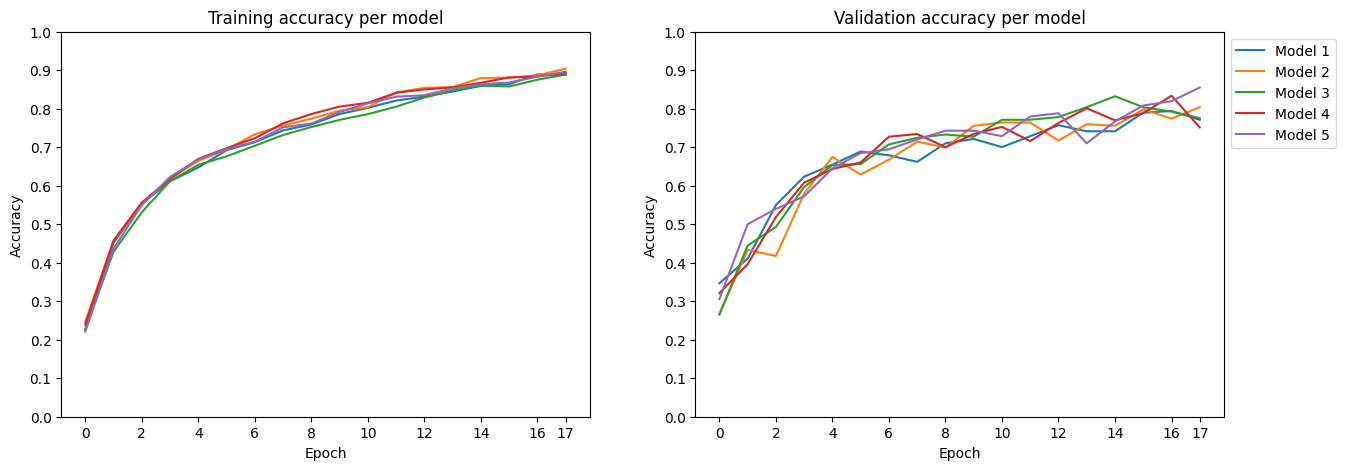

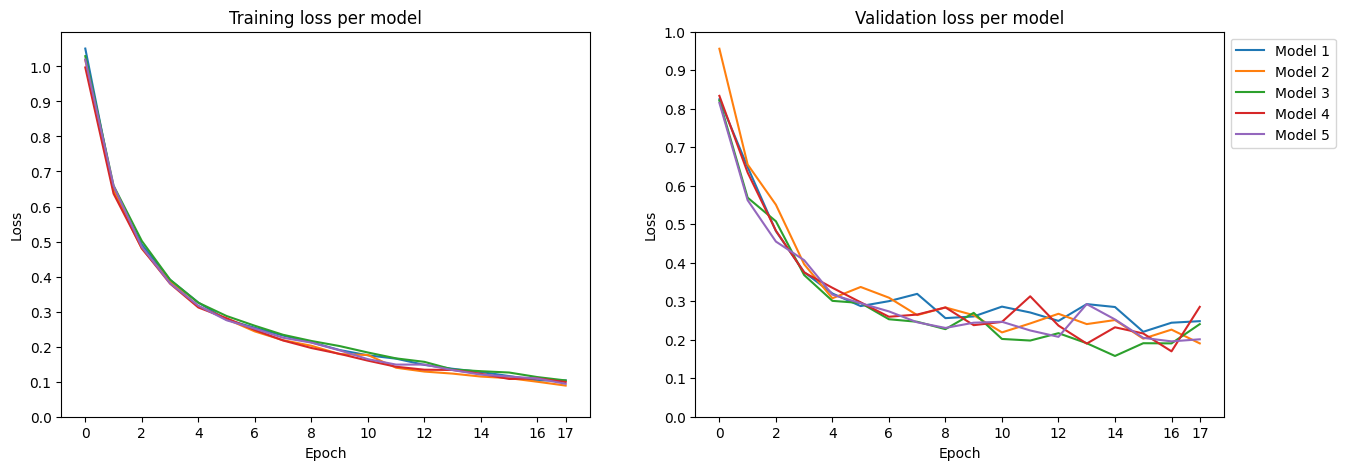

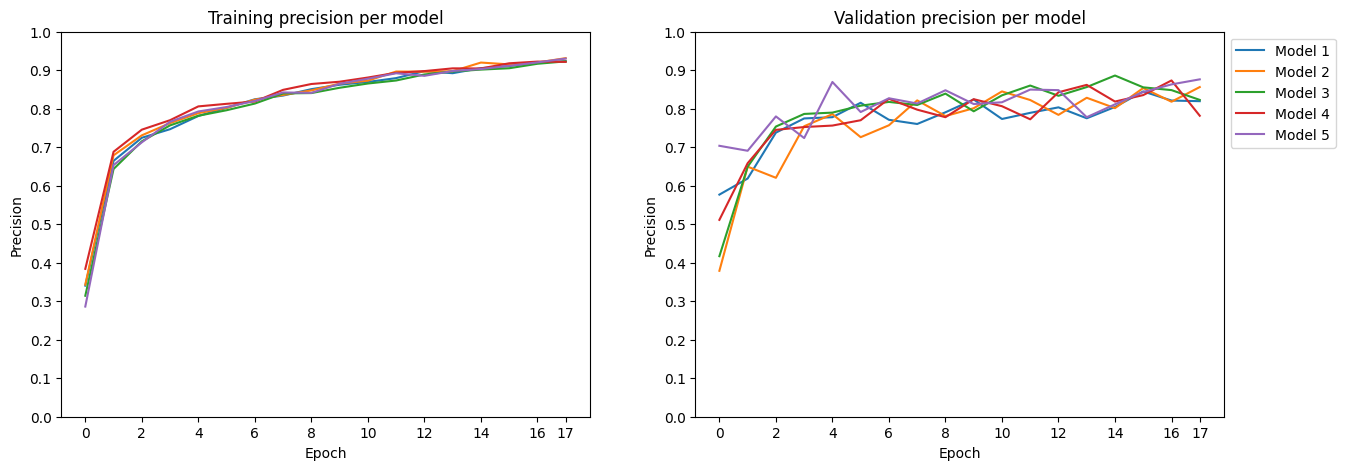

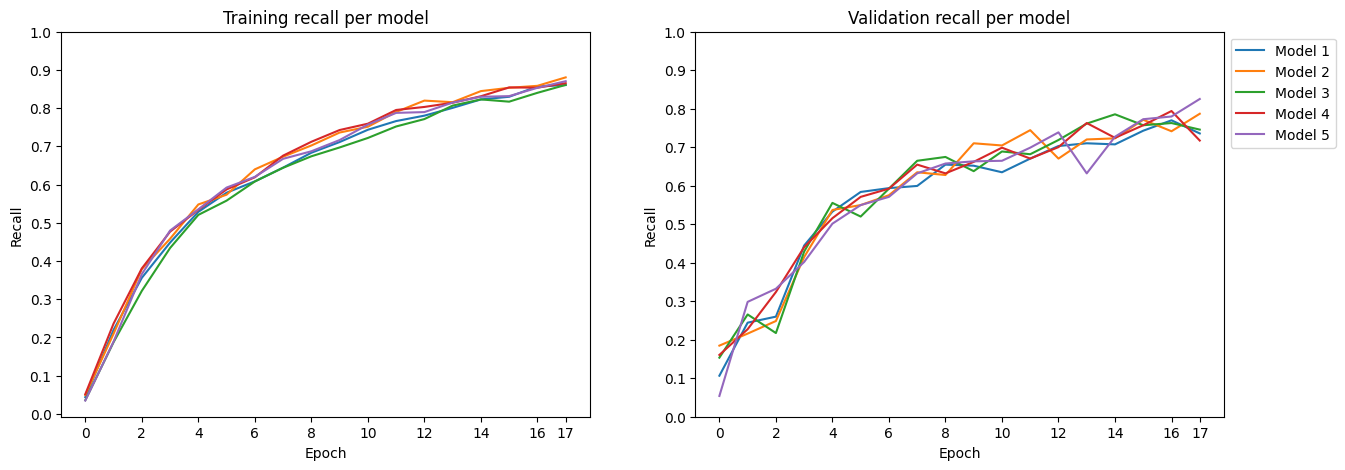

In [20]:
# Visualising training results over time
# Helper function to make plots easily for different metrics
def plot_googlenet_scores(ax, metric, title, ylabel):
    # Plot the score for each model from 5-fold
    for history in googlenet_scores:
        ax.plot(history.history[metric])
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    ax.set_xticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 17])
    ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

plt.figure(figsize=(15, 5))
# Training accuracy
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'output_accuracy', 'Training accuracy per model', 'Accuracy')

# Validation accuracy
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_output_accuracy', 'Validation accuracy per model', 'Accuracy')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(15, 5))
# Training loss
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'loss', 'Training loss per model', 'Loss')

# Validation loss
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_loss', 'Validation loss per model', 'Loss')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(15, 5))
# Training precision
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'output_precision', 'Training precision per model', 'Precision')

# Validation precision
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_output_precision', 'Validation precision per model', 'Precision')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(15, 5))
# Training recall
ax = plt.subplot(1, 2, 1)
plot_googlenet_scores(ax, 'output_recall', 'Training recall per model', 'Recall')

# Validation recall
ax = plt.subplot(1, 2, 2)
plot_googlenet_scores(ax, 'val_output_recall', 'Validation recall per model', 'Recall')
ax.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Now, we will evaluate each of our models against the test set and print out their results. At the end we will also get the average of each metric and loss. <br>
The results in testing each model are worse than in training and validation. Each metric was on average about 10% lower than it's validation counterpart and loss increased by about 0.1 on average.

In [91]:
# Evaluate each model and print the results
def print_evaluation(name, evaluation):
    print(f'{name} test loss: {round(evaluation[0], 4)}')
    print(f'{name} test accuracy: {round(evaluation[1]*100, 1)}%')
    print(f'{name} test precision: {round(evaluation[2]*100, 1)}%')
    print(f'{name} test recall: {round(evaluation[3]*100, 1)}%')
    
googlenet_evaluations = []

# Printing test results for each model
for idx, model in enumerate(googlenet_models):
    evaluation = model.evaluate(test_ds)
    print_evaluation(f'GoogLeNet {idx+1}', evaluation)
    googlenet_evaluations.append(evaluation)

# Getting the average evaluation scores for all models
googlenet_evaluations = np.sum(googlenet_evaluations, axis=0)
avg_loss = round((googlenet_evaluations[0] / 5), 4)
avg_accuracy = round((googlenet_evaluations[1] / 5), 4)
avg_precision = round((googlenet_evaluations[2] / 5), 4)
avg_recall = round((googlenet_evaluations[3] / 5), 4)

# Print the average metrics
print(f'\nAverage loss: {avg_loss}')
print(f'Average accuracy: {avg_accuracy*100}%')
print(f'Average Precision: {avg_precision*100}%')
print(f'Average Recall: {avg_recall*100}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.3985 - output_accuracy: 0.6290 - output_precision: 0.7000 - output_recall: 0.6043
GoogLeNet 1 test loss: 0.3996
GoogLeNet 1 test accuracy: 63.8%
GoogLeNet 1 test precision: 70.3%
GoogLeNet 1 test recall: 60.4%
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.3195 - output_accuracy: 0.7051 - output_precision: 0.7649 - output_recall: 0.6670
GoogLeNet 2 test loss: 0.3199
GoogLeNet 2 test accuracy: 71.1%
GoogLeNet 2 test precision: 75.7%
GoogLeNet 2 test recall: 66.6%
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.4172 - output_accuracy: 0.6647 - output_precision: 0.7038 - output_recall: 0.6228
GoogLeNet 3 test loss: 0.4032
GoogLeNet 3 test accuracy: 66.3%
GoogLeNet 3 test precision: 70.8%
GoogLeNet 3 test recall: 62.7%
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.4409 - output_accuracy: 0.6580 - output_precision: 0.6916 - output_recall: 0.6368
GoogLeNet 4 test loss: 0.4469
GoogLeNet 4 test accuracy: 65.8%
GoogLeNet 4 test prec

We will now try aggregating the predictions made by each model and comparing the results of that against the individual models' results. <br>
To do this, we will use both average predictions and majority voting. <br>
 - Average predictions simply add all the predictions together and divide by the number of models to get the mean. Then, we evaluate the predictions normally.
 - Majority voting involved taking the predicted class for each instance in our training set from each model. Then we get the class that is predicted the most often (the mode) and set that to be our prediction.
Both methods saw a significant increase in performance showing the potential behind aggregating results from cross fold validation. This confirms that the 5 models learned some features differently and thus by combining them, we can in part take advantage of this more robust set of identified features. Average prediction got slightly better results so we will look into these predictions.

In [92]:
# Aggregating our models to get an average prediction

# Extracting test images and labels from the dataset
X_test = [] # Array of images
y_test = [] # Array of labels corresponding to the images
for x_t, y_t in test_ds:
    for i in range(x_t.shape[0]):
        X_test.append(x_t[i].numpy())
        y_test.append(y_t[i].numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)
# True labels
y_true = np.argmax(y_test, axis=1)

# Get the predictions for each model for the test data
googlenet_predictions = []
for model in googlenet_models:
    prediction = model.predict(X_test)
    googlenet_predictions.append(np.array(prediction[0]))

# To get the average predicted label we first average the predictions
avg_googlenet_predictions = np.mean(googlenet_predictions, axis=0)
# Then we get the highest mean probablity for each classification
avg_googlenet_predictions = np.argmax(avg_googlenet_predictions, axis=1)
# Now we can calculate the metrics
print('\nResults for the average prediction made by all models')
print(f'Accuracy: {accuracy_score(y_true, avg_googlenet_predictions)*100:.4f}%')
print(f'Precision: {precision_score(y_true, avg_googlenet_predictions, average='macro')*100:.4f}%')
print(f'Recall: {recall_score(y_true, avg_googlenet_predictions, average='macro')*100:.4f}%')

# We will also get the most commonly predicted label by a majority vote
# First we get the most commonly predicted label for each model
majority_googlenet_predictions = np.array([np.argmax(prediction, axis=1) for prediction in googlenet_predictions])
# Then we get the mode (most commonly predicted label) for all the models
majority_googlenet_predictions, _ = mode(majority_googlenet_predictions, axis=0)

print('\nResults for the majority prediction made by all models')
print(f'Accuracy: {accuracy_score(y_true, majority_googlenet_predictions)*100:.4f}%')
print(f'Precision: {precision_score(y_true, majority_googlenet_predictions, average='macro')*100:.4f}%')
print(f'Recall: {recall_score(y_true, majority_googlenet_predictions, average='macro')*100:.4f}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step

Results for the average prediction made by all models
Accuracy: 75.4824%
Precision: 76.3947%
Recall: 75.4070%

Results for the majority prediction made by all models
Accuracy: 74.1203%
Precision: 75.1881%
Recall: 74.0930%


To better understand our results we will compute a confusion matrix using the average predictions calculated in the previous code block. <br>
It's important to note when reading the confusion matrix results that each test label has 100 images except label 0 and label 5 which have 92 and 89 images respectively. So a lower number of correct predictions here might not mean worse performance. <br>
A perfect confusion matrix would have all 0s everywhere except the diagonal, which would indicate that we predicted the correct class every time. <br>
We can use the results to gain insights into where our model performs well, and where it struggles and we can examine the wrong classifications to try and figure out why.

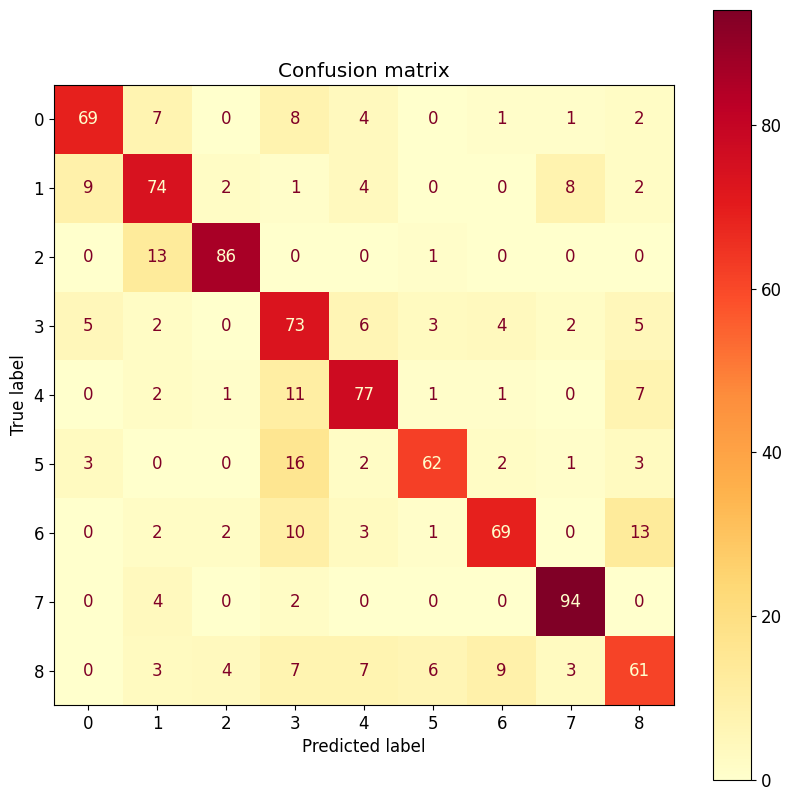

In [97]:
# Computing the confusion matrix using average predictions
cm = confusion_matrix(y_true, avg_googlenet_predictions)
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(10, 10))

# Plotting confusion matrix
cm_display.plot(ax=ax, cmap="YlOrRd")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

### 6.2 ResNext results

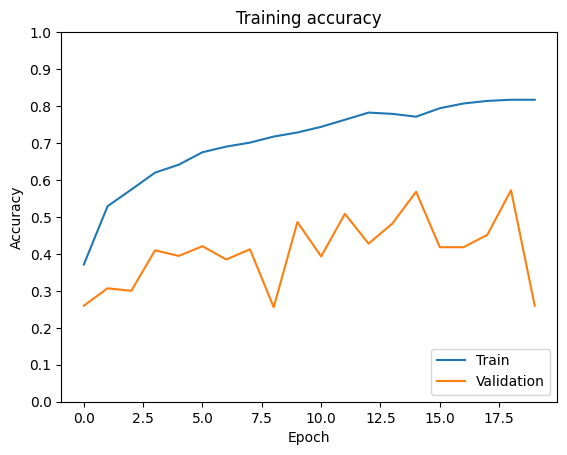

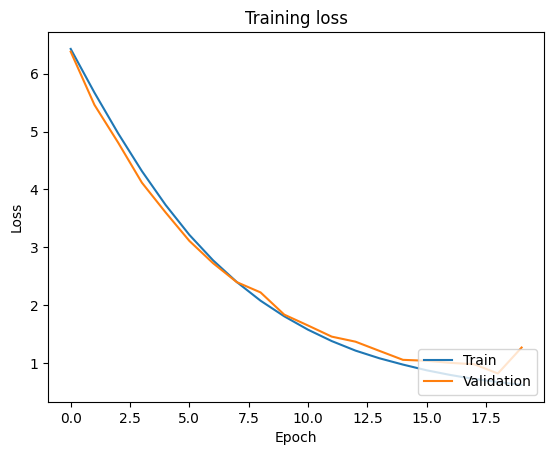

In [ ]:
# Plotting accuracy over training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plotting loss over training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
evaluation = model.evaluate(test_ds)
print(f'ResNeXT test loss: {round(evaluation[0], 4)}')
print(f'ResNeXT test accuracy: {round(evaluation[1]*100, 1)}%')

28/28 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.1561 - loss: 3.9347
ResNeXT test loss: 3.9827
ResNeXT test accuracy: 14.4%


In [ ]:
model_tiny_smart = ResNext((256, 256, 3), depth=29, cardinality=8, width=4)
model_tiny_two = model_tiny_smart
model_tiny_dumb = model_tiny_smart

# Compiling the models with a few different learning rates and epochs

#Very low learning rate, avg. number of epochs
model_tiny_smart.compile(optimizer=Lion(learning_rate=0.000035), loss=categorical_focal_crossentropy, metrics=['accuracy'])
historthree = model_tiny_smart.fit(train_ds, epochs=30,validation_data=valid_ds, validation_freq=1)

#Slightly larger learning rate with more epochs
model_tiny_two.compile(optimizer=Lion(learning_rate=0.000048), loss=categorical_focal_crossentropy, metrics=['accuracy'])
histfoury = model_tiny_smart.fit(train_ds, epochs=35,validation_data=valid_ds, validation_freq=1)

#Huge learning rate, many epochs
model_tiny_two.compile(optimizer=Lion(learning_rate=0.007), loss=categorical_focal_crossentropy, metrics=['accuracy'])
histor_v = model_tiny_smart.fit(train_ds, epochs=15,validation_data=valid_ds, validation_freq=1)

model_tiny_smart.evaluate(test_ds)
model_tiny_two.evaluate(test_ds)
model_tiny_dumb.evaluate(test_ds)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1035 - loss: 3.6493 - val_accuracy: 0.1236 - val_loss: 4.0498
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - accuracy: 0.2070 - loss: 3.5541 - val_accuracy: 0.1125 - val_loss: 3.7190
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 636ms/step - accuracy: 0.2749 - loss: 3.4946 - val_accuracy: 0.1486 - val_loss: 3.5821
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - accuracy: 0.3165 - loss: 3.4487 - val_accuracy: 0.1750 - val_loss: 3.5241
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 634ms/step - accuracy: 0.3277 - loss: 3.4156 - val_accuracy: 0.1861 - val_loss: 3.5001
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 635ms/step - accuracy: 0.3445 - loss: 3.3809 - val_accuracy: 0.1639 - val_loss: 3.4834
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 634ms/step - accuracy: 0.3696 - loss: 3.3498 - val_accuracy: 0.1750 - val_loss: 3.4531
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 634ms/step - accuracy: 0.4058 - loss: 3.3068 - val_accurac

[1.595108151435852, 0.1668558418750763]

**The Great ResNext Validation Tournament**
******

A set of three models with a width of 4, each tested to see their performance.



*   A model with a very low learning rate and 30 epochs
*   A model with a slightly higher learning rate and 35 epochs
*   A purposely bad model with a huge learning rate and only 15 epochs

Predictably, model 3 quickly overfitted and performed poorly. However, model 2 slightly edged out model 1, with a somewhat respectable validation accuracy of 61.25% and a training accuracy of 74.83%. Curiously, none of these models performed well on the testing data after training, possibly due to an imbalanced dataset.

Below we will visualise what was going on with these strange testing results.

In [ ]:
# Get our predictions
resnext_predictions = model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step


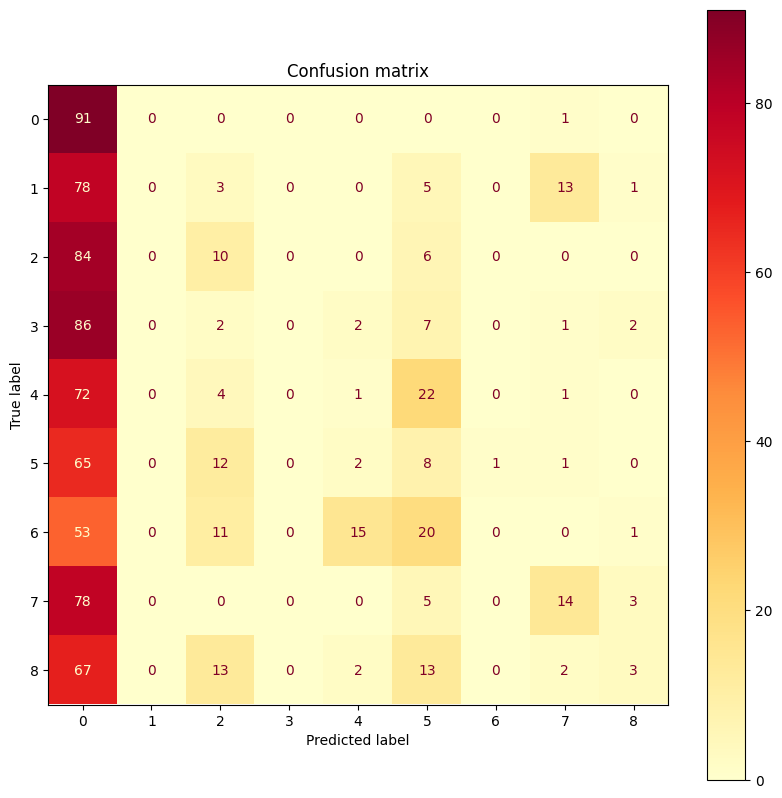

In [ ]:
# Computing the confusion matrix using ResNeXT's predictions
resnext_predictions = np.argmax(resnext_predictions, axis=1)
cm = confusion_matrix(y_true, resnext_predictions)
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(10, 10))

# Plotting confusion matrix
cm_display.plot(ax=ax, cmap="YlOrRd")
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

## 7 Evaluation
### 7.1 GoogLeNet
To address the elephant in the room, it's clear that our GoogLeNet models are having difficulty in generalising. The training metrics are about 10% better than the validation metrics which are about 10% better than the testing metrics so there is some overfitting happening. While aggregating predictions significantly increased model performance let's first look into why our model might be overfitting. <br><br>
- Firstly, our dataset is pretty small considering the complexity of GoogLeNet. The auxiliary classifiers should help in backpropagation of gradients but cannot fully account for a lack of training data. With more training data our model will likely be able to learn features of the classes better. <br>
 -Another point is the use of normalisation. Batch normalisation and dropout is used within the model but a lot of convolutional and dense layers don't have normalisation before or after them. In fact adding more batch normalisation layers increased training performance but lowered validation accuracy and caused a lot of variance, making our overfitting problem worse. L2 regularisation had minimal to no effect on the training process when tested and altering dropout rates also had minimal effect, although we did settle on a lower dropout rate for the auxiliary classifiers as with our relatively small dataset, 70% could just be too high. <br>
- To mitigate the effects of overfitting, cross-fold validation was of great help. Each fold uses a unique validation set meaning that the features learned each fold won't all overlap as the training set is also different for each fold. It follows that by combining the features learned in each fold we will have better predictions and that is what we observed. <br><br>

Our confusion matrix is based on the average predictions of the folds combined. <br>
- The first note is that the replacement of bad test data (lavenders) worked as desired and our model was able to predict label 2 (lavender) quite well. <br>
- Label 7 (sunflower) was the most accurate, with 94/100 predictions being correct. These classes likely performed better than the others since the flowers have unique colours (purple and yellow) that didn't appear commonly in the other classes. Dandelions (label 1) are also yellow but since our dataset contains flowering and seeding dandelions, the association is not as strong since seeding dandelions are a light shade of grey and have no yellow. <br>
- Label 3 (lilly) was predicted the most often, 128 times. Label 4 (lotus) and 5 (orchid) were confused for label 3 most often. This could be due to them all appearing in various colours, often white and pink, and they all have broad leaves that narrow toward the ends. <br>
- Label 8 (tulip) was predicted correctly the least. It was often confused for label 6 (rose). This is likely because these flowers are often photographed from the side and from that angle are of similar shape. On top of this they are often shades of red. 7 false negatives went to label 4 (lotus) which is likely to come from the fact that, before they bloom, lotuses look very similar to tulips, and they both are likely to appear in shades of pink. <br><br>

Overall it seems that the model may have been too complex for the amount of training data we had, and in retrospect, supplementing the dataset with additional images or choosing a larger dataset could have yielded better results.

### 7.2 ResNext

The main takeaway from this model summary is the sheer size. This is mostly due to the width parameter in the model constructor, which controls the size of each layer. The original version of this model is shown in in our diagram below, where the width was set to 64. For reference, we signed up for Google Colab Pro for use of their highest-power machines, and this model burned through all 360GB of available RAM. To actually run this model, we opted to reduce the width parameter to 8, then 4.

The severe memory requirements ResNext comes with is actually quite a limiter. One must balance the size and effectiveness of the model with the number of epochs it can run through before crashing the machine. To reach its full potential, one would need access to a HPC unit. This was an error in our planning, as if we had hired out the El Capitan computer, currently the number one ranked machine on the [Top500](https://top500.org/), ResNext MIGHT have been able to run in its desired state.

## 8 Bonus: FCN32 architecture
<b>Disclaimer</b>: We looked at the FCN32 architecture as the unknown architecture initially, but working through it made us realize that we couldn't make use of two of the most interesting features of the FCN structure. First, FCNs can deal with differently shaped data, which would make any scaling in preprocessing unnecessary. However, while the model itself could theoretically deal with that, the fit function of Keras didn't accept the differently shaped batches we provided through a generator. Secondly, a great advantage is getting an output for every pixel. However, since we wanted to achieve an overall classification instead of a segmentation and that's also what we had as a ground truth, we couldn't really make use of pixelwise predictions. Thus, we decided to instead focus on the ResNeXt as the previously unknown architecture and still wanted to at least keep in the architecture of the FCN32 as another interesting example.

### Weight Initialization
The FCN32 makes use of a pretrained VGG16 model, thus weights are set based on prior training of the model with a different dataset. The last layer of the FCN32, the Convolution Transpose layer, makes use of a custom initializer, the Bilinear Initializer. The Convolution Transpose layer is used for upsampling the output of the previous layer to the original image size to get labels for each pixel. The Bilinear Initializer prepares learning this task by creating an initial kernel with weights that get interpolated in such a way that the weight is largest in the center of the Kernel and reduces its height towards the edges. All other kernel weights in the FCN32 model are initialized with the Glorot uniform initializer, whereas biases are initialized with the Zeros initializer. Both are the default initilalizers Keras offers for layers in their model.

#### The Glorot uniform initializer
Weights are sampled from a uniform distribution (specific form of probability distribution) with bounds that depends on the input and output of the corresponding layer. It controls the variance and thus helps prevent issues like vanishing or exploding gradients during training.

#### The Zeros initializer
Weights are initially all set to 0.

### Activation Functions
FCN32 uses ReLU as an activation function, Softmax for the final output and a linear activation function for the layer before the last one (similar to GoogleLeNet). GoogleLeNet additionally uses the Softmax in the last layer of its auxillary classifier.

#### Linear Activation Function
Returns its input; This is only used in one layer of both models, where we do not need to introduce more complexity or non-linearity to the model, but need to produce our final classification (either with a fully connected layer as in GoogleLeNet or a Convolutional Layer with Kernel size 1 in the FCN32).

- Formula: f(x) = x
### Batch Normalization
There is no batch normalization in the FCN32, different from GoogleLeNet and ResNeXt.

### Regularization
FCN32 and ResNeXt use L2 regularization, GoogleLeNet and FCN32 use Drop out layers and GoogleLeNet and ResNeXt use batch normalization, which also has a regularizing effect.

### Distinguishing Features
FCN32 substitutes fully connected output layers (as evident in the GoogleLeNet) with Convolutions with Kernels of size 1x1.

In [ ]:
from collections import namedtuple

# Hyperparameter, could directly be used to adapt values in architecture
ConvLayer = namedtuple('ConvLayer', ['stride', 'kernel_size', 'padding'])
cnn_structure = [
    ConvLayer(stride=1, kernel_size=3, padding=0)
]

def FCN(len_classes = 5, dropout_rate=0.2):

  #Input layer
  input = tf.keras.layers.Input(shape=(None,None,3))

  #Conv block
  x = tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #This decreases the height and width of our input image.
  #In order to find the minimum usable image size, we can repeatedly stack these convolution blocks.

  #You can also use dense layers by uncommenting this line, but it requires a bit of extra work to get running on the image
  #x = tf.keras.layers.GlobalMaxPooling2D()(x)

  #Dense FCL 1
  #x = tf.keras.layers.Dropout(dropout_rate)(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  #x = tf.layers.Dense(units=64)(x)
  #x = tf.keras.layers.Activation('relu')(x)

  #Fully Connected Layer 1
  x = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 1)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #Dense FCL 2
  #x = tf.keras.layers.Dropout(dropout_rate)(x)
  #x = tf.keras.layers.BatchNormalization()(x)
  #x = tf.layers.Dense(units=len_classes)(x)
  #predictions = tf.keras.layers.Activation('softmax')(x)

  #Fully Connected Layer 2
  x = tf.keras.layers.Conv2D(filters = len_classes, kernel_size = 1, strides = 1)(input)
  x = tf.keras.layers.Dropout(dropout_rate)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.GlobalMaxPooling2D()(x)
  x = tf.keras.layers.Activation('relu')(x)
  predictions = tf.keras.layers.Activation('softmax')(x)

  model = tf.keras.Model(inputs=input, outputs=predictions)
  print(model.summary())
  return model

'''def construct_image_batch(image_group, BATCH_SIZE):
  #Get our max image shape
  max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))

  #Make an image batch object
  image_batch = np.zeroes((BATCH_SIZE,) + max_shape, dtype = 'float32')

  #Copy images to upper left part of image batch
  for image_index, image in enumerate(image_group):
    image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

  return image_batch'''

def train(model, train_generator, val_generator, epochs):
  #Compiling our model
  model.compile(optimizer=tf.keras.optimizers.Lion(learning_rate=0.0001),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

  #Storing the model
  path = './snapshots'
  os.makedirs(path, exist_ok=True)
  model_path = os.path.join(path, 'model_epoch_{epoch:02d}_loss_{loss:.2f}_accuracy__{accuracy:.2f}_val_loss_{val_loss:.2f}_val_accuracy_{val_accuracy:.2f}.keras')

  history = model.fit(train_generator,
                                steps_per_epoch = len(train_generator),
                                epochs = epochs,
                                callbacks = [tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only=True, verbose = 1)],
                                validation_data = val_generator,
                                validation_steps = len(val_generator))
  return history

def export_model(input, export_path):
  #A method that takes a .h5 file and saves it for us
  tf.keras.backend.set_learning_phase(0) #Ignore dropout at inference point!
  model = tf.keras.models.load_model(input)
  model.save(export_path, save_format = 'tf')

# Determines minimum needed shape of an image to be processed by the network correctly
# Based on the formula to calculate the output of a single convolutional layer,
# given here: https://cs231n.github.io/convolutional-networks/#conv
# Output Shape = (W-F+2P)/S+1
# where
#   W...Shape of the input
#   F...Receptive field size (equivalent to kernel size)
#   S...Stride
# With known minimum output (which is 1x1) of all convolutional layers before
# 1x1 convolution, minimum input shapes for data can be determined
# args: cnn_structure: List of convolutions with kernel size (receptive field size), stride and padding
def minimum_input_size(cnn_structure):
  output = 1  # Reduction to consideration of only one dimension, since final minimum output is 1x1xFilter size, filter size is predetermined and both other dimensions will be treated equally
  for cnn in reversed(cnn_structure):
    min_in = cnn.stride*(output-1)+cnn.kernel_size-2*cnn.padding
    output = min_in
  return output

In [ ]:
import cv2
from sklearn import preprocessing

# Generator provides train method continuously with data, structured in batches
# Thus, not all data at once has to be stored in memory, but only one batch
# at a time. It also offers more dynamical processing of the data, which can
# be done on the fly per batch.
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, DATASET_PATH, BATCH_SIZE=32, shuffle_images=True, image_min_side=24, max_shape = (24, 24, 3)):
    """ Initialize Generator object.

    Args
        DATASET_PATH           : Path to folder containing individual folders named by their class names
        BATCH_SIZE             : The size of the batches to generate.
        shuffle_images         : If True, shuffles the images read from the DATASET_PATH
        image_min_side         : After resizing the minimum side of an image is equal to image_min_side.
    """

    self.batch_size = BATCH_SIZE
    self.shuffle_images = shuffle_images
    self.image_min_side = image_min_side
    self.load_image_paths_labels(DATASET_PATH)
    self.create_image_groups()

    # USED FOR RESCALING TO ENSURE COMMON SHAPE ACROSS BATCHES: 
    # this was one adaptation we tried to still be able to use the generator (dynamically providing the data) 
    # although providing differently shaped data to the fit function did not work
    self.max_shape = max_shape
    if max_shape[0]<image_min_side:
      warnings.warn('Defined common image height falls short of the minimum. Will be set to the minimum.')
      max_shape = (image_min_side, max_shape[1], max_shape[2])
    if max_shape[1]<image_min_side:
      warnings.warn('Defined common image width falls short of the minimum. Will be set to the minimum.')
      max_shape = (max_shape[0], image_min_side, max_shape[2])

  # Creates list of all paths to the input images and of the corresponding
  # labels
  def load_image_paths_labels(self, DATASET_PATH):
    classes = os.listdir(DATASET_PATH)
    lb = preprocessing.LabelBinarizer()
    lb.fit(classes)  # Binarization of categorical output data

    self.image_paths = []
    self.image_labels = []
    for class_name in classes:
        class_path = os.path.join(DATASET_PATH, class_name)
        for image_file_name in os.listdir(class_path):
            self.image_paths.append(os.path.join(class_path, image_file_name))
            self.image_labels.append(class_name)

    self.image_labels = np.array(lb.transform(self.image_labels), dtype='float32')

    assert len(self.image_paths) == len(self.image_labels)

  # Used to assign batches that can be loaded separately
  def create_image_groups(self):
    if self.shuffle_images:
        # Randomly shuffle dataset
        seed = 4321  # Making randomness reproducible
        np.random.seed(seed)
        np.random.shuffle(self.image_paths)
        np.random.seed(seed)
        np.random.shuffle(self.image_labels)

    # Divide image_paths and image_labels into the same groups of BATCH_SIZE
    self.image_groups = [[self.image_paths[x % len(self.image_paths)] for x in range(i, i + self.batch_size)]
                          for i in range(0, len(self.image_paths), self.batch_size)]
    self.label_groups = [[self.image_labels[x % len(self.image_labels)] for x in range(i, i + self.batch_size)]
                          for i in range(0, len(self.image_labels), self.batch_size)]

  # Used to ensure the minimum size of an image input, which is determined by
  # the network structure
  # Determination if smaller side of the image is smaller than the minimum
  # If it is, this is the side that gets enlarged to meet the minimum criterion
  # and the second side will get adapted accordingly to remain the aspect ratio
  def resize_image(self, img, min_side_len):
    h, w, c = img.shape

    if min(h, w) < min_side_len:
        im_scale = float(min_side_len) / h if h < w else float(min_side_len) / w
    else:
        im_scale = 1.

    # USED FOR RESCALING TO ENSURE COMMON SHAPE ACROSS BATCHES
    if h*im_scale > self.max_shape[0]:
        im_scale = self.max_shape[0]/h  # This can never increase the im_scale compared to before, but the minimum will be maintained at least by the padding
    if w*im_scale > self.max_shape[1]:
        im_scale = self.max_shape[1]/w  # This can never increase the im_scale compared to before

    new_h = int(h * im_scale)
    new_w = int(w * im_scale)

    re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return re_im, new_h / h, new_w / w

  # Read all images of one prespecified group from file
  def load_images(self, image_group):
    images = []
    for image_path in image_group:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, rh, rw = self.resize_image(img, self.image_min_side)
        images.append(img)

    return images

  # All images of one batch get a zero-padding to the same shape, which is the
  # maximum shape of that batch
  def construct_image_batch(self, image_group):
    # get the max image shape -> OUTCOMMENTED TO ENSURE COMMON SHAPE ACROSS ALL BATCHES
    #max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))
    # USED TO ENSURE COMMON SHAPE ACROSS BATCHES
    max_shape = self.max_shape

    print("Max Shape: ", str(max_shape))

    # construct an image batch object
    image_batch = np.zeros((self.batch_size,) + max_shape, dtype='float32')

    print(f"Batch shape: {image_batch.shape}")
    # copy all images to the upper left part of the image batch object
    for image_index, image in enumerate(image_group):
        image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

    return image_batch

  def __len__(self):
    """
    Number of batches for generator.
    """
    return len(self.image_groups)

  # Produces the data in batches that get fed into the training method
  def __getitem__(self, index):
    """
    Keras sequence method for generating batches.
    """
    image_group = self.image_groups[index]
    label_group = self.label_groups[index]
    images = self.load_images(image_group)
    image_batch = self.construct_image_batch(images)

    return np.array(image_batch), np.array(label_group)

In [ ]:
model = FCN(len_classes=NB_CLASSES, dropout_rate=0.2)
image_min_side = image_min_side = minimum_input_size(cnn_structure)

# determine the maximum of the first batch to use in both training and testing
max_shape_first_batches = (0,0,0)
train_ds.batch(batch_size)
for batch, labels in train_ds:
  for image in batch:
    print(batch.shape)
    print(image.shape)
    max_shape_first_batches = tuple(max(image.shape[x], max_shape_first_batches[x]) for x in range(3))
    break
  break

train_generator = DataGenerator(train_dir, batch_size, shuffle_images = True, image_min_side = image_min_side, max_shape = max_shape_first_batches)
val_generator = DataGenerator(test_dir, batch_size, shuffle_images=True, image_min_side=image_min_side, max_shape = max_shape_first_batches)
epochs = 50
history = train(model, train_generator, val_generator, epochs=epochs)

**Uncovered architecture - Fully Connected Network**

A fully connected network is built by taking a regular VGG-16 model, then adding a number of Fully Connected layers on top of it. Each tier of layers upgrades the model, going from FCN 32 to 16 to 8.

IMAGE PROCESSING: The FCN works by taking an image, then downsizing it and getting the outlines. The downsized image with the outlines (called a 'label') will be deconvolutionised to return it to its former size. This is done through 32x upsampling with the first round of Fully Cnneected Layers, giving the FCN-32 its name.

The label output will be rough due to going deep into the layers, so it must then be enhanced using element-wise addition.

This will then be repeated for the FCN-16 and FCN-8 layers, using 16x and 8x unsampling respectively. The label map will get less rough each time, resulting in clearer outlines and colour blocks.

COMPARISON BETWEEN MODELS

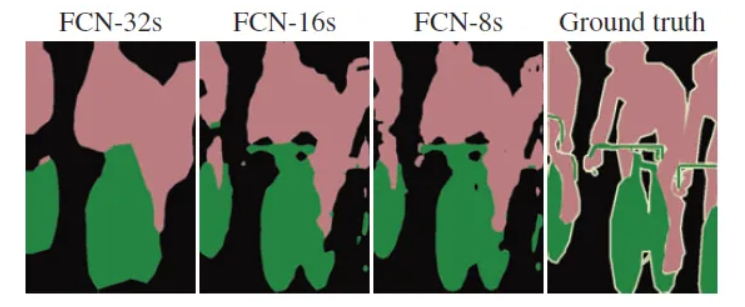

**FCN32**

Below are diagrams representing the architecture of FCN32.

Reference: https://github.com/kevinddchen/Keras-FCN/tree/main

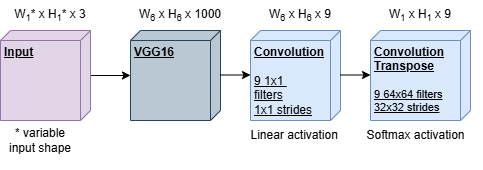

*FCN32*

In [ ]:
#Utility block!

"""
This file contains useful methods for handling image files.
"""

import numpy as np
import tensorflow as tf
import scipy.io # to read .mat files
from PIL import Image # to read image files

PALETTE = np.reshape([
    0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128,
    128, 128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0,
    128, 192, 0, 128, 64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0,
    192, 0, 128, 192, 0, 0, 64, 128, 128, 64, 128, 0, 192, 128, 128, 192, 128,
    64, 64, 0, 192, 64, 0, 64, 192, 0, 192, 192, 0, 64, 64, 128, 192, 64, 128,
    64, 192, 128, 192, 192, 128, 0, 0, 64, 128, 0, 64, 0, 128, 64, 128, 128,
    64, 0, 0, 192, 128, 0, 192, 0, 128, 192, 128, 128, 192, 64, 0, 64, 192, 0,
    64, 64, 128, 64, 192, 128, 64, 64, 0, 192, 192, 0, 192, 64, 128, 192, 192,
    128, 192, 0, 64, 64, 128, 64, 64, 0, 192, 64, 128, 192, 64, 0, 64, 192,
    128, 64, 192, 0, 192, 192, 128, 192, 192, 64, 64, 64, 192, 64, 64, 64, 192,
    64, 192, 192, 64, 64, 64, 192, 192, 64, 192, 64, 192, 192, 192, 192, 192,
    32, 0, 0, 160, 0, 0, 32, 128, 0, 160, 128, 0, 32, 0, 128, 160, 0, 128, 32,
    128, 128, 160, 128, 128, 96, 0, 0, 224, 0, 0, 96, 128, 0, 224, 128, 0, 96,
    0, 128, 224, 0, 128, 96, 128, 128, 224, 128, 128, 32, 64, 0, 160, 64, 0,
    32, 192, 0, 160, 192, 0, 32, 64, 128, 160, 64, 128, 32, 192, 128, 160, 192,
    128, 96, 64, 0, 224, 64, 0, 96, 192, 0, 224, 192, 0, 96, 64, 128, 224, 64,
    128, 96, 192, 128, 224, 192, 128, 32, 0, 64, 160, 0, 64, 32, 128, 64, 160,
    128, 64, 32, 0, 192, 160, 0, 192, 32, 128, 192, 160, 128, 192, 96, 0, 64,
    224, 0, 64, 96, 128, 64, 224, 128, 64, 96, 0, 192, 224, 0, 192, 96, 128,
    192, 224, 128, 192, 32, 64, 64, 160, 64, 64, 32, 192, 64, 160, 192, 64, 32,
    64, 192, 160, 64, 192, 32, 192, 192, 160, 192, 192, 96, 64, 64, 224, 64,
    64, 96, 192, 64, 224, 192, 64, 96, 64, 192, 224, 64, 192, 96, 192, 192,
    224, 192, 192, 0, 32, 0, 128, 32, 0, 0, 160, 0, 128, 160, 0, 0, 32, 128,
    128, 32, 128, 0, 160, 128, 128, 160, 128, 64, 32, 0, 192, 32, 0, 64, 160,
    0, 192, 160, 0, 64, 32, 128, 192, 32, 128, 64, 160, 128, 192, 160, 128, 0,
    96, 0, 128, 96, 0, 0, 224, 0, 128, 224, 0, 0, 96, 128, 128, 96, 128, 0,
    224, 128, 128, 224, 128, 64, 96, 0, 192, 96, 0, 64, 224, 0, 192, 224, 0,
    64, 96, 128, 192, 96, 128, 64, 224, 128, 192, 224, 128, 0, 32, 64, 128, 32,
    64, 0, 160, 64, 128, 160, 64, 0, 32, 192, 128, 32, 192, 0, 160, 192, 128,
    160, 192, 64, 32, 64, 192, 32, 64, 64, 160, 64, 192, 160, 64, 64, 32, 192,
    192, 32, 192, 64, 160, 192, 192, 160, 192, 0, 96, 64, 128, 96, 64, 0, 224,
    64, 128, 224, 64, 0, 96, 192, 128, 96, 192, 0, 224, 192, 128, 224, 192, 64,
    96, 64, 192, 96, 64, 64, 224, 64, 192, 224, 64, 64, 96, 192, 192, 96, 192,
    64, 224, 192, 192, 224, 192, 32, 32, 0, 160, 32, 0, 32, 160, 0, 160, 160,
    0, 32, 32, 128, 160, 32, 128, 32, 160, 128, 160, 160, 128, 96, 32, 0, 224,
    32, 0, 96, 160, 0, 224, 160, 0, 96, 32, 128, 224, 32, 128, 96, 160, 128,
    224, 160, 128, 32, 96, 0, 160, 96, 0, 32, 224, 0, 160, 224, 0, 32, 96, 128,
    160, 96, 128, 32, 224, 128, 160, 224, 128, 96, 96, 0, 224, 96, 0, 96, 224,
    0, 224, 224, 0, 96, 96, 128, 224, 96, 128, 96, 224, 128, 224, 224, 128, 32,
    32, 64, 160, 32, 64, 32, 160, 64, 160, 160, 64, 32, 32, 192, 160, 32, 192,
    32, 160, 192, 160, 160, 192, 96, 32, 64, 224, 32, 64, 96, 160, 64, 224,
    160, 64, 96, 32, 192, 224, 32, 192, 96, 160, 192, 224, 160, 192, 32, 96,
    64, 160, 96, 64, 32, 224, 64, 160, 224, 64, 32, 96, 192, 160, 96, 192, 32,
    224, 192, 160, 224, 192, 96, 96, 64, 224, 96, 64, 96, 224, 64, 224, 224,
    64, 96, 96, 192, 224, 96, 192, 96, 224, 192, 224, 224, 192], (-1, 3))



def get_image(path):
    '''Retrieve image as array of RGB values from .jpg file.

    Args:
      path (string): Path to .jpg file

    Returns:
      (array<np.uint8>): RGB values for each pixel. Shape=(height, width, 3)
    '''
    jpg = Image.open(path).convert('RGB')
    return np.array(jpg)



def get_label_mat(path):
    '''Retrieve class labels for each pixel from Berkeley SBD .mat file.

    Args:
      path (string): Path to .mat file

    Returns:
      (array<np.uint8>): Class as an integer in [0, 20] for each pixel. Shape=(height, width, 1)
    '''
    mat = scipy.io.loadmat(path)
    arr = mat['GTcls']['Segmentation'].item(0,0) # this is how segmentation is stored
    return arr[..., None]



def get_label_png(path):
    '''Retrieve class labels for each pixel from Pascal VOC .png file.

    Args:
      path (string): Path to .png file

    Returns:
      (array<np.uint8>): Class as an integer in [-1, 20], where -1 is boundary, for each pixel. Shape=(height, width, 1)
    '''
    png = Image.open(path) # image is saved as palettised png. OpenCV cannot load without converting.
    arr = np.array(png)
    return arr[..., None]



def label_to_image(label, palette=PALETTE):
    '''Converts class labels to color image using a palette.

    Args:
      label (array<np.uint8>): Class labels for each pixel. Shape=(height, width, 1)
      palette (array<np.uint8>): RGB values for each class. Shape=(255, 3)

    Returns:
      (array<np.uint8>): RGB values for each pixel. Shape=(height, width, 3)
    '''
    return palette[label[..., 0]].astype(np.uint8)



def label_to_onehot(label, num_classes=21):
    '''Converts class labels to its one-hot encoding.

    Args:
      label (array<np.uint8>): Class labels for each pixel. Shape=(height, width, 1)

    Returns:
      (array<np.uint8>): One-hot encoding of class labels for each pixel. Boundary is ignored.
        Shape=(height, width, num_classes)
    '''
    return (np.arange(21) == label).astype(np.uint8)



def onehot_to_label(arr):
    '''Opposite of label_to_onehot().'''
    arr = np.argmax(arr, axis=-1).astype(np.uint8)
    return arr[..., None]

def get_example(image, label):
    '''Given image and label, produce a tf Example that can be written to a .tfrecords file.

    Args:
      image (array<np.uint8>): Shape=(height, width, 3)
      label (array<np.uint8>): Shape=(height, width, 1)

    Returns:
      (tf Example)
    '''
    ## Usage:
    #with tf.io.TFRecordWriter(PATH_TO_TFRECORDS) as writer:
    #    writer.write(get_example(image, label).SerializeToString())
    feature = {
        'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[image.shape[0]])),
        'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[image.shape[1]])),
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.tobytes()])),
        'label': tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.tobytes()]))
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))



def parse_example(example):
    '''Parse tf Example to obtain image and label.

    Args:
      example (tf Example)

    Returns:
      image (array<np.uint8>): Shape=(height, width, 3)
      label (array<np.uint8>): Shape=(height, width, 1)
    '''
    ## Usage:
    #dataset = tf.data.TFRecordDataset(PATH_TO_TFRECORDS).map(parse_example)
    feature_description = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
    }
    dct = tf.io.parse_single_example(example, feature_description)
    height = dct['height']
    width = dct['width']
    image = tf.reshape(tf.io.decode_raw(dct['image'], out_type=tf.uint8), (height, width, 3))
    label = tf.reshape(tf.io.decode_raw(dct['label'], out_type=tf.uint8), (height, width, 1))
    return image, label

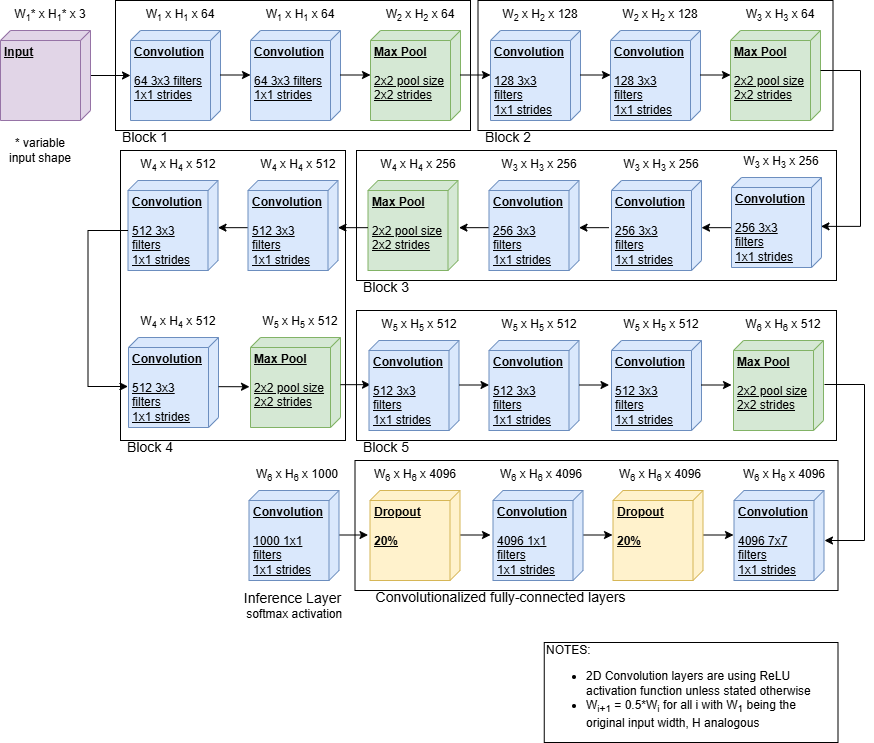

*VGG16*

In [ ]:
import keras

#A method to make a VGG-16 FCN model using Keras
def vgg16(l2, dropout):
  #Params: l2 strength and Dropout rate, for regularisations

  input_layer = keras.Input(shape=(None, None, 3), name='input')

  #Preprocessing
  x = keras.layers.Lambda(keras.applications.vgg16.preprocess_input, name='preprocessing')(input_layer)

  #Convolution Block 1: Filter size: 64, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block1_conv1')(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3,  strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block1_conv2')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block1_pool')(x)

  #Convolution Block 2: Filter size: 128, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block2_conv1')(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3,  strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block2_conv2')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block2_pool')(x)

  #Convolution Block 3: Filter size: 256, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv1')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv2')(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block3_conv3')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block3_pool')(x)

  #Convolution Block 4: Filter size: 512, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv1')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv2')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block4_conv3')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block4_pool')(x)

  #Convolution Block 4: Filter size: 512, Kernel Size: 3x3, Stride = 1
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv1')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv2')(x)
  x = keras.layers.Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='block5_conv3')(x)
  x = keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid', name='block5_pool')(x)

  #Convolutionized fully-connected layers

  #Layer 6: Filter size: 4096, Kernel size = 7x7, Stride = 1
  x = keras.layers.Conv2D(filters=4096, kernel_size=(7,7), strides=(1,1), padding='same', activation='relu',kernel_regularizer=keras.regularizers.L2(l2=l2), name='conv6')(x)
  x = keras.layers.Dropout(rate=dropout, name='drop6')(x)

  #Layer 7: Filter size: 4096, Kernel size = 1x1, Stride = 1
  x = keras.layers.Conv2D(filters=4096, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu', kernel_regularizer=keras.regularizers.L2(l2=l2), name='conv7')(x)
  x = keras.layers.Dropout(rate=dropout, name='drop7')(x)

  #Inference layer (1000 filters, 1x1 Kernel, Stride of 1)
  x = keras.layers.Conv2D(filters=1000, kernel_size=(1,1), strides=(1,1), padding='same', activation='softmax', name='pred')(x)
  return keras.Model(input_layer, x)

#Now that we have our VGG model, we can add extra layers to build up to the FCN-8
def fcn32(vgg16, l2):
    '''32x upsampled FCN.

    Args:
      vgg16 (keras Model): VGG16 model to build upon
      l2 (float): L2 regularization strength

    Returns:
      (keras Model)
    '''

    #Making new layers and adding them onto our VGG-16
    x = keras.layers.Conv2D(filters=9, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear', kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score7')(vgg16.get_layer('drop7').output)
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(64,64), strides=(32,32),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn32')(x)
    return keras.Model(vgg16.input, x)

def fcn16(vgg16, fcn32, l2=0):
    '''16x upsampled FCN.

    Args:
      vgg16 (keras Model): VGG16 model to build upon
      fcn32 (keras Model): FCN32 model to build upon
      l2 (float): L2 regularization strength

    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='score7_upsample')(fcn32.get_layer('score7').output)
    y = keras.layers.Conv2D(filters=9, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score4')(vgg16.get_layer('block4_pool').output)
    x = keras.layers.Add(name='skip4')([x, y])
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(32,32), strides=(16, 16),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn16')(x)
    return keras.Model(fcn32.input, x)


def fcn8(vgg16, fcn16, l2=0):
    '''8x upsampled FCN.

    Args:
      vgg16 (keras Model): VGG16 model to build upon
      fcn16 (keras Model): FCN16 model to build upon
      l2 (float): L2 regularization strength

    Returns:
      (keras Model)
    '''
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(4,4), strides=(2,2),
                                     padding='same', use_bias=False, activation='linear',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='skip4_upsample')(fcn16.get_layer('skip4').output)
    y = keras.layers.Conv2D(filters=9, kernel_size=(1,1), strides=(1,1), padding='same', activation='linear',
                            kernel_initializer=keras.initializers.Zeros(),
                            kernel_regularizer=keras.regularizers.L2(l2=l2),
                            name='score3')(vgg16.get_layer('block3_pool').output)
    x = keras.layers.Add(name='skip3')([x, y])
    x = keras.layers.Conv2DTranspose(filters=9, kernel_size=(16,16), strides=(8,8),
                                     padding='same', use_bias=False, activation='softmax',
                                     kernel_initializer=BilinearInitializer(),
                                     kernel_regularizer=keras.regularizers.L2(l2=l2),
                                     name='fcn8')(x)
    return keras.Model(fcn16.input, x)


## ================
## Misc functions for training
## ================

class BilinearInitializer(keras.initializers.Initializer):
    '''Initializer for Conv2DTranspose to perform bilinear interpolation on each channel.'''
    def __call__(self, shape, dtype=None, **kwargs):
        kernel_size, _, filters, _ = shape
        arr = np.zeros((kernel_size, kernel_size, filters, filters))
        ## make filter that performs bilinear interpolation through Conv2DTranspose
        upscale_factor = (kernel_size+1)//2
        if kernel_size % 2 == 1:
            center = upscale_factor - 1
        else:
            center = upscale_factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        kernel = (1-np.abs(og[0]-center)/upscale_factor) * \
                 (1-np.abs(og[1]-center)/upscale_factor) # kernel shape is (kernel_size, kernel_size)
        for i in range(filters):
            arr[..., i, i] = kernel
        return tf.convert_to_tensor(arr, dtype=dtype)



def crossentropy(y_true, y_pred_onehot):
    '''Custom cross-entropy to handle borders (class = -1).'''
    n_valid = tf.math.reduce_sum(tf.cast(y_true != 255, tf.float32))
    y_true_onehot = tf.cast(np.arange(21) == y_true, tf.float32)
    return tf.reduce_sum(-y_true_onehot * tf.math.log(y_pred_onehot + 1e-7)) / n_valid

def pixelacc(y_true, y_pred_onehot):
    '''Custom pixel accuracy to handle borders (class = -1).'''
    n_valid = tf.math.reduce_sum(tf.cast(y_true != 255, tf.float32))
    y_true = tf.cast(y_true, tf.int32)[..., 0]
    y_pred = tf.argmax(y_pred_onehot, axis=-1, output_type=tf.int32)
    return tf.reduce_sum(tf.cast(y_true == y_pred, tf.float32)) / n_valid



class MyMeanIoU(keras.metrics.MeanIoU):
    '''Custom meanIoU to handle borders (class = -1).'''
    def update_state(self, y_true, y_pred_onehot, sample_weight=None):
        y_pred = tf.argmax(y_pred_onehot, axis=-1)
        ## add 1 so boundary class=0
        y_true = tf.cast(y_true+1, self._dtype)
        y_pred = tf.cast(y_pred+1, self._dtype)
        ## Flatten the input if its rank > 1.
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        ## calculate confusion matrix with one extra class
        current_cm = tf.math.confusion_matrix(
            y_true,
            y_pred,
            self.num_classes+1,
            weights=sample_weight,
            dtype=self._dtype)
        return self.total_cm.assign_add(current_cm[1:, 1:]) # remove boundary

In [ ]:
#Make a VGG model
base_model = vgg16(l2=1e-6, dropout=0.2)

In [ ]:
#Load VGG-16 Image weights
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')
weight_list = vgg16.get_weights()
weight_list[26] = weight_list[26].reshape(7, 7, 512, 4096)
weight_list[28] = weight_list[28].reshape(1, 1, 4096, 4096)
weight_list[30] = weight_list[30].reshape(1, 1, 4096, 1000)
base_model.set_weights(weight_list)
del weight_list

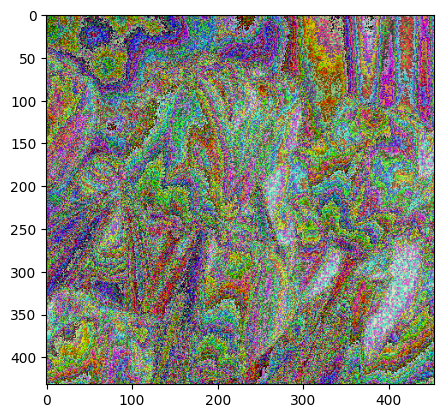

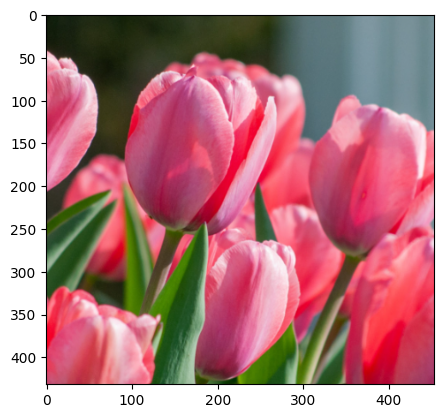

Top three guesses with probabilities:
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
309
301
310


In [ ]:
#Training the model

img = get_image('/content/tuliptest.png')
plt.imshow(label_to_image(img))
plt.figure()
plt.imshow(img)
plt.show()

print('Top three guesses with probabilities:')
probs = base_model.predict(img[None])[0, 3, 3] # pick the central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(3):
    c = pred[i]
    print(c)
    #print("{0:s} (p={1:.3f})".format(class_names[c], probs[c]))

In [ ]:
#Freezable layers for experimentation!
fcn32 = fcn32(base_model, 1e-6)
# fcn32.get_layer('block1_conv1').trainable=False
# fcn32.get_layer('block1_conv2').trainable=False
# fcn32.get_layer('block2_conv1').trainable=False
# fcn32.get_layer('block2_conv2').trainable=False
# fcn32.get_layer('block3_conv1').trainable=False
# fcn32.get_layer('block3_conv2').trainable=False
# fcn32.get_layer('block3_conv3').trainable=False
# fcn32.get_layer('block4_conv1').trainable=False
# fcn32.get_layer('block4_conv2').trainable=False
# fcn32.get_layer('block4_conv3').trainable=False
# freeze upsample layer
fcn32.get_layer('fcn32').trainable=False

In [ ]:
#Bring in the FCN-16, with custom-freezable layers
fcn16 = fcn16(base_model, fcn32, l2=1e-6)

# fcn16.get_layer('block4_conv1').trainable=True
# fcn16.get_layer('block4_conv2').trainable=True
# fcn16.get_layer('block4_conv3').trainable=True
# freeze upsample layer
fcn16.get_layer('score7_upsample').trainable=False
fcn16.get_layer('fcn16').trainable=False

In [ ]:
#Build up an FCN8 over our FCN16
fcn8 = fcn8(base_model, fcn16, l2=1e-6)
#Custom-freezable layers

# fcn8.get_layer('block1_conv1').trainable=True
# fcn8.get_layer('block1_conv2').trainable=True
# fcn8.get_layer('block2_conv1').trainable=True
# fcn8.get_layer('block2_conv2').trainable=True
# fcn8.get_layer('block3_conv1').trainable=True
# fcn8.get_layer('block3_conv2').trainable=True
# fcn8.get_layer('block3_conv3').trainable=True
# freeze upsample layer
fcn8.get_layer('skip4_upsample').trainable=False
fcn8.get_layer('fcn8').trainable=False

Training Blocks

In [ ]:
## Load model
model = fcn32
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Lambda)               │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv6 (Conv2D)                       │ (None, None, None, 4096)    │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 136,152,917 (519.38 MB)

 Trainable params: 134,346,581 (512.49 MB)

 Non-trainable params: 1,806,336 (6.89 MB)

In [ ]:
#Compile our model
#opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Lamb(learning_rate=1e-4) #The original optimiser function here was Adam, but we opted to use Lamb, which is geared towards larger datasets
loss = crossentropy
metrics = [loss,
           pixelacc,
           MyMeanIoU(num_classes=21, name='meanIoU')]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
import numpy as np
import tensorflow as tf

#Image resizer for preprocessing

#def resize_with_pad(image, label, size=512):
def resize_with_pad(image, label, size=512):
    '''Resize a square while keeping the original aspect ratio, padding with black for the image and boundary
    for the label.

    Args:
      image (array<np.uint8>): RGB values for each pixel. Shape=(height, width, 3)
      label (array<np.uint8>): Class labels for each pixel. Shape=(height, width, 1)
      size (int): length of square

    Returns:
      (array<np.uint8>): Resized image. Shape=(size, size, 3)
      (array<np.uint8>): Resized label. Shape=(size, size, 1)
    '''
    image = tf.image.resize_with_pad(image, size, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    ## since `resize_with_pad` pads with zeros, use fact that boundary class is -1 to pad with -1 instead.
    #label = tf.image.resize_with_pad(label+1, size, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)-1
    #return image, label
    return image

In [ ]:
#Split data into training and testing!

train = train_ds.shuffle(1000).unbatch().batch(16)
test = test_ds.shuffle(1000).unbatch().batch(16)

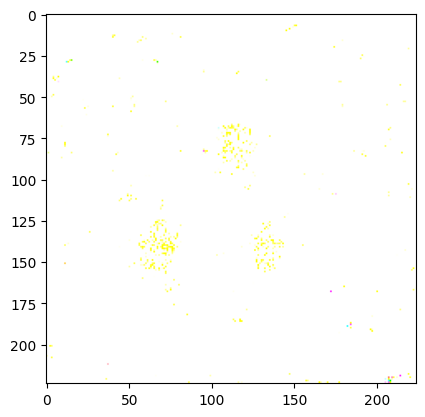

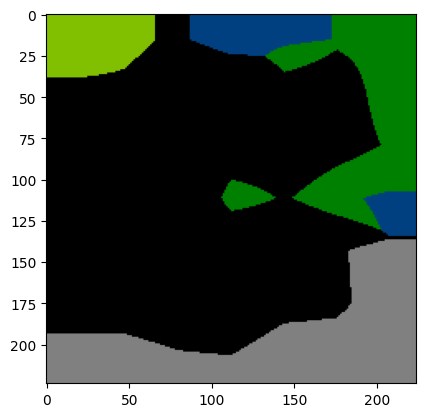

In [ ]:
#Test our model!
for X, y in test.unbatch().shuffle(100).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()

    #plt.figure()
    #plt.imshow(label_to_image(y[0]))
    #plt.show()

    plt.figure()
    plt.imshow(label_to_image(onehot_to_label(model(X)[0])))
    plt.show()
    #model.evaluate(X, y)

## 9 References:
Our dataset: <br>
[National Flowers](https://www.kaggle.com/datasets/shahidulugvcse/national-flowers) <br><br>
Additional lavender test images sources: <br>
https://unsplash.com/s/photos/lavender <br>
https://www.pexels.com/search/lavender <br><br>
GoogLeNet paper: <br>
[Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842) <br><br>
GoogLeNet example implementation: <br>
[Implementation of GoogLeNet on Keras](https://lekhuyen.medium.com/implementation-of-googlenet-on-keras-d9873aeed83c) <br><br>
Keras Tuner (Hyperband): <br>
[Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) <br><br>
TensorFlow Documentation: <br>
[API Documentation | TensorFlow v2.16.1](https://www.tensorflow.org/api_docs) <br><br>
Matplotlib documentation: <br>
[Matplotlib Docs](https://matplotlib.org/stable/) <br><br>
Keras Documentation: <br>
[Keras 3 API documentation](https://keras.io/api/) <br><br>
ResNext-50 Implementation used as a guide <br>
[ResNext-50 Implementation](https://www.kaggle.com/code/yasserh/resnext-50-implementation) <br><br>
FCN Implementation <br>
[Keras-FCN](https://github.com/kevinddchen/Keras-FCN/blob/main/models.py)